# Phish no more: phishing email detection

## By Salma Houmane (Matrikel-Nr: 822192)

###### This file contains the code for replicating the analysis in the term paper.  I ran the latest version of the analysis on a macOS Sonoma 14.4 operating system with an English dictionary to account for vowel mutations and special characters. The replication files comprise several Jupyter Notebooks. The scripts run under Python-version 3.12.4 packaged by Anaconda but a few more additional packages may have to be installed. 

###### We organized the replication folder as follows. To replicate the analysis, paste the python code and data into one folder. Open the main script and enter your working directory. Make sure that your operating system accounts for vowel mutations, special characters, and that the additional packages were installed. Note, the computation of the machine learning model may take up to 2.5 hours. Comments guide you through the code.

In [3]:
InstallPackages = False
if InstallPackages:
    import sys
    !{sys.executable} -m pip install pandas
    !{sys.executable} -m pip install nltk
    !{sys.executable} -m pip install spacy
    !{sys.executable} -m pip install numpy
    !{sys.executable} -m pip install gensim
    !{sys.executable} -m pip install matplotlib
    !{sys.executable} -m pip install seaborn
    !{sys.executable} -m pip install pyspellchecker
    !{sys.executable} -m pip install scikit-learn
    !{sys.executable} -m pip install wordninja
    !{sys.executable} -m pip install inflect
    !{sys.executable} -m pip install wordcloud
    !{sys.executable} -m pip install autocorrect
    !{sys.executable} -m pip install xgboost
    !{sys.executable} -m!pip install beautifulsoup4 
    !{sys.executable} -m!pip install contractions
    !{sys.executable} -m!pip install Unidecode
    !{sys.executable} -m!pip install textblob
    !{sys.executable} -m!pip install eng-spacysentiment
    !{sys.executable} -m!pip install scikit-plot
    !{sys.executable} -m!pip install spacy spacytextblob
    !{sys.executable} -m!pip install transformers
    !{sys.executable} -m!pip install tensorflow
    !{sys.executable} -m!pip install tf-keras

In [4]:
import sys
import pandas as pd
import nltk
import pydantic
import spacy
import numpy as np
import csv
import os
import re
import collections
import seaborn as sns
import wordninja
import inflect
from matplotlib import pyplot as plt
from spellchecker import SpellChecker
import nltk
from nltk import ngrams
from nltk.corpus import words, wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from sklearn.cluster import KMeans
from gensim.models.fasttext import load_facebook_model
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from pprint import pprint
from sklearn.decomposition import PCA
import warnings
from datetime import time
from autocorrect import Speller
import bs4 
import contractions
import unidecode
from textblob import TextBlob
from unidecode import unidecode
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from spellchecker import SpellChecker
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from transformers import pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [5]:
warnings.filterwarnings('ignore')

In [6]:
DownloadAdditions = False
if DownloadAdditions:
    nltk.download("stopwords")
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('words')
    nltk.download('punkt')
    nltk.download("wordnet")
    spacy.cli.download("en_core_web_lg")

In [7]:
 nlp = spacy.load("en_core_web_lg")

## SEED

In [8]:
seed = 42

## CORPUS CREATION

In [9]:
csv_file_path = "CEAS_08.csv"


In [10]:
df = pd.read_csv(csv_file_path)

##### We now check if the data is uploaded correctly and have an overview of the dataset

In [11]:
df.head()

sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  SpamAssassin Dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   

                              date  \
0  Tue, 05 Aug 2008 16:31:02 -0700   
1  Tue, 05 Aug 2008 18:31:03 -0500   
2  Tue, 05 Aug 2008 20:28:00 -1200   
3  Tue, 05 Aug 2008 17:31:20 -0600   
4  Tue, 05 Aug 2008 19:31:21 -0400   

                                             subject  \
0                          Never agree to be a loser   
1                             Befriend Jenna Jameson   
2                               CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/tru...   
4                         SpecialPricesPharmMoreinfo   

                                                body  label  urls  
0  Buck up, your troubles caused by small dimensi...      1     1  
1  \nUpgrade your sex and pleasures with these te...      1     1  
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1     1  
3  Would anyone object to removing .so from this ...      0     1  
4  \nWelcomeFastShippingCustomerSupport\nhttp://7...      1     1

##### We check the types of variables and how many are missing

In [12]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64

## Summary Statistics of the Data and Data Analysis

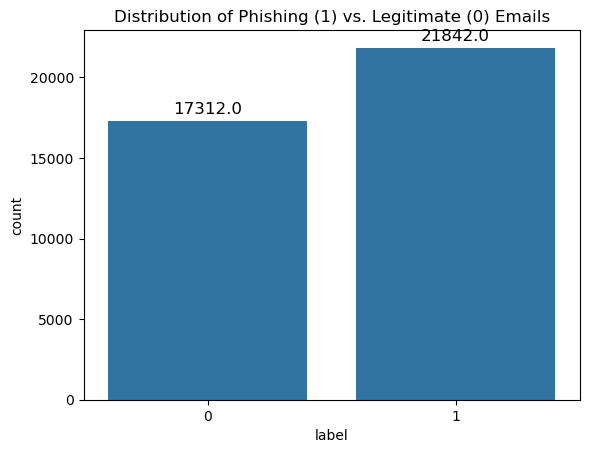

In [13]:
# Distribution of the label column
# Create the count plot
ax = sns.countplot(x='label', data=df)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Add title to the plot
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')

# Show the plot
plt.show()

The dataset we have, containing 21,842 spam (phishing) emails and 17,312 legitimate emails, provides a substantial amount of data for building a phishing detection machine learning model.

##### We now check if there are any trends in the subject column of the dataset

In [14]:
# Count the number of rows with the same subject
subject_counts = df['subject'].value_counts()

# Print the counts of each unique subject
print("Counts of each unique subject:")
print(subject_counts)

# Calculate the percentage of unique subjects
total_rows = df.shape[0]
unique_subjects = df['subject'].nunique()
unique_percentage = (unique_subjects / total_rows) * 100

print(f'\nTotal rows: {total_rows}')
print(f'Number of unique subjects: {unique_subjects}')
print(f'Percentage of unique subjects: {unique_percentage:.2f}%')
print(f'Percentage of unique subjects: {unique_percentage:.2f}%')

Counts of each unique subject:
subject
CNN.com Daily Top 10                             2930
CNN Alerts: My Custom Alert                      1406
Re:                                               580
123                                               255
Re:                                               125
                                                 ... 
Happy Birthday wishes from Rochelle                 1
Quiet prices for must have products.                1
[PownceAPI] Re: Verify credentials                  1
[Python-3000] u'text' as an alias for 'text'?       1
[Python-Dev] PEP 370 heads up                       1
Name: count, Length: 15436, dtype: int64

Total rows: 39154
Number of unique subjects: 15436
Percentage of unique subjects: 39.42%
Percentage of unique subjects: 39.42%


We see a lot of emails have the topic CNN and RE. These objects sound suspicious so in a next step, we check if CNN objects are used more in phishing emails.

In [15]:
# Filter the DataFrame where the email is phishing confirmed
df_label_1 = df[df['label'] == 1]

# Count the number of rows with the same subject
subject_counts_label_1 = df_label_1['subject'].value_counts()

# Print the counts of each unique subject for label=1
print("Counts of each unique subject where label=1:")
print(subject_counts_label_1)

# Calculate the percentage of unique subjects for label=1
total_rows_label_1 = df_label_1.shape[0]
unique_subjects_label_1 = df_label_1['subject'].nunique()
unique_percentage_label_1 = (unique_subjects_label_1 / total_rows_label_1) * 100

print(f'\nTotal number of phishing emails=1: {total_rows_label_1}')
print(f'Number of unique subjects in phishing emails: {unique_subjects_label_1}')
print(f'Percentage of unique subjects in phishing emails: {unique_percentage_label_1:.2f}%')

Counts of each unique subject where label=1:
subject
CNN.com Daily Top 10                                                        2930
CNN Alerts: My Custom Alert                                                 1406
Re:                                                                          580
123                                                                          255
Re:                                                                          123
                                                                            ... 
Low shipping costs, you will spend less when you buy your remedy with us       1
From Concetta Rosenberg                                                        1
50 ways to meet your lover_olesia_k                                            1
TakeALookThankYouYourHealth                                                    1
Woman 38 Richter                                                               1
Name: count, Length: 6419, dtype: int64

Total number of

Our theory was true: most emails with the object CNN are indeed phishing. We will create a CNN variable that takes the value 1 when CNN is in the subject and 0 otherwise.

##### A next step is to check if there are known senders that are 'phishers'

In [16]:
# Find the top 10 senders
top_10_senders = df_label_1['sender'].value_counts().head(10)

# Print the top 10 senders
print("Top 10 senders where label=1:")
print(top_10_senders)

Top 10 senders where label=1:
sender
<>                                                     44
Google AdWords-noreply <adwords-noreply@google.com>    36
Google AdWords <reactivation@google.com>               30
Google-AdWords-noreply <adwords-noreply@google.com>    29
Google-AdWords <reactivation@google.com>               25
Google-AdWords-Noreply <support@google.com>            23
AdWords-NoReplay <adwords-noreply@google.com>          21
Google AdWords <adwords-noreply@google.com>            16
Google-AdWords <adwords-noreply@google.com>            16
Google-AdWords <support-adwords@google.com>            12
Name: count, dtype: int64


We see that the sender Google Adwords as well as Adwords No Replay seem to be phishers. We will create a variable adwords that take the value 1 when adwords is in the sender and 0 otherwise. 

##### We now check for any daily trends or hourly trends with spam emails

In [17]:
# Check the datatype before conversion
print(df['date'].dtype) 

object


In [18]:
# Convert 'date' column to UTC before conversion to datetime64
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')


In [19]:
# Check the datatype after conversion
print(df['date'].dtype) 

datetime64[ns, UTC]


In [20]:
# Dropping rows with NaT values in the 'date' column
df = df.dropna(subset=['date'])

# Creating separate columns for Date and Time
df['Date'] = df['date'].dt.date
df['Time'] = df['date'].dt.time

In [21]:
# Add a new column for the day of the week
df['DAY_OF_WEEK'] = df['date'].dt.dayofweek
# Add a new column to indicate if the email happened on a Friday
df['IS_FRIDAY'] = df['date'].dt.dayofweek == 4
# Add a new column for the hour of the email
df['HOUR'] = df['date'].dt.hour

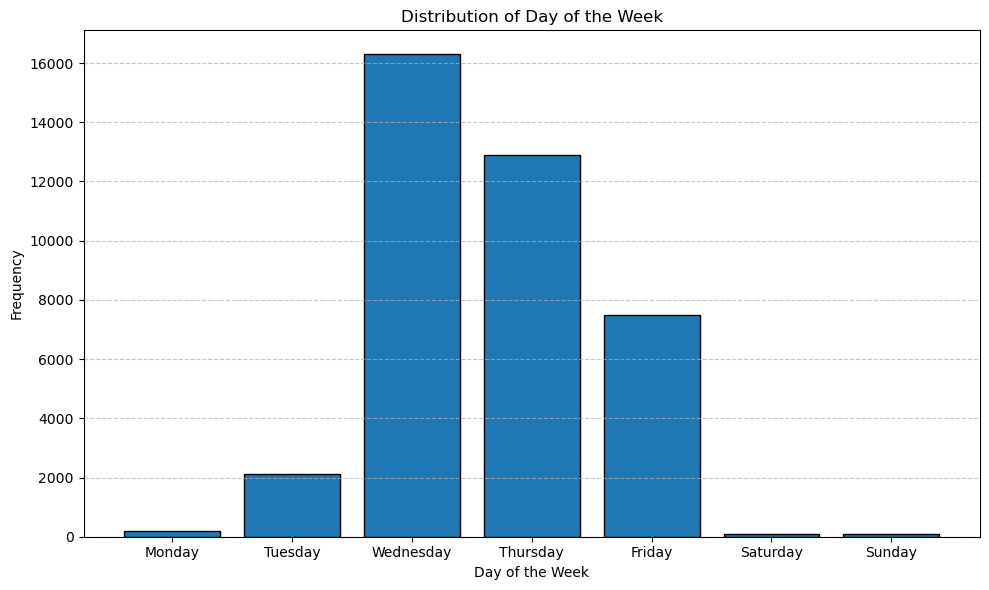

In [22]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['DAY_OF_WEEK'], bins=range(8), edgecolor='black', align='left', rwidth=0.8)

# Customize the plot
plt.title('Distribution of Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Most emails are sent between Wednesday and Friday and that makes sense. Very little emails over the weekend as well as Monday.

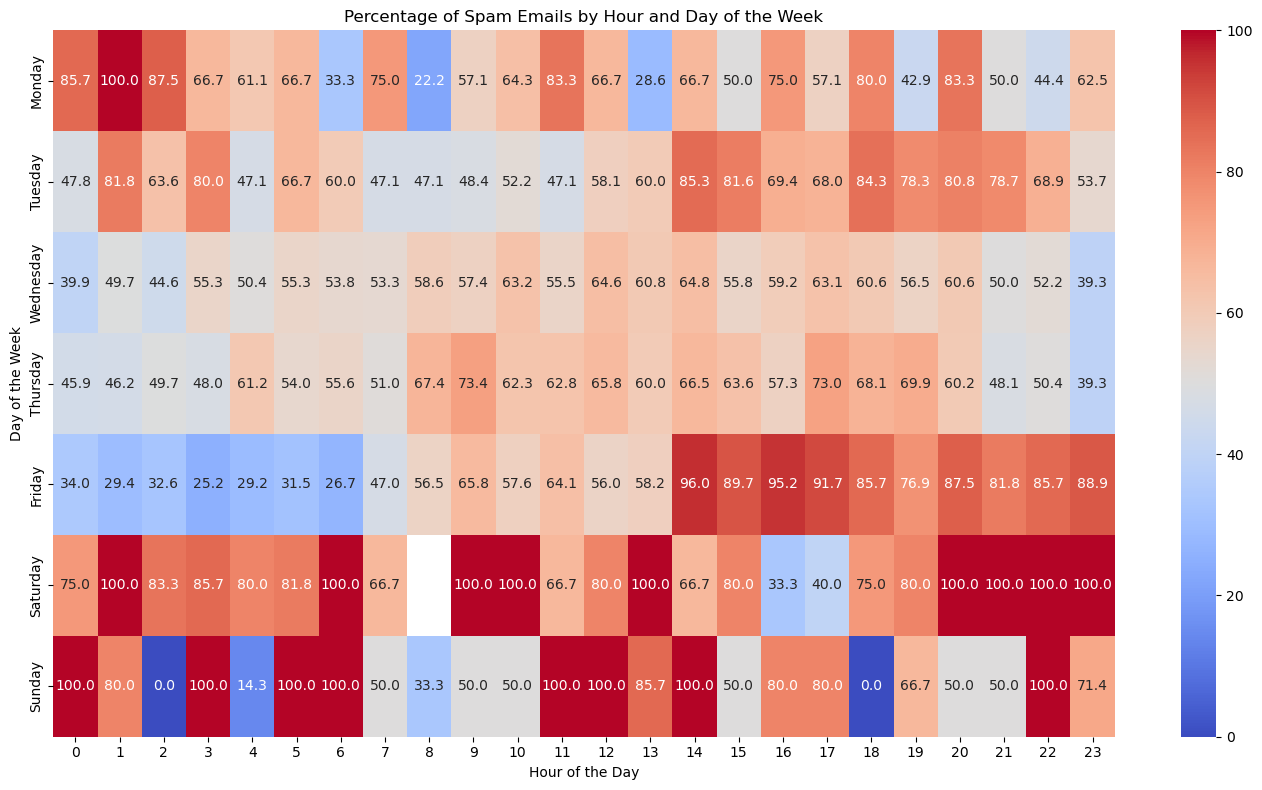

In [23]:
# Convert 'DAY_OF_WEEK' from integer to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DAY_NAME'] = df['DAY_OF_WEEK'].map(lambda x: day_names[x])

# Ensure 'DAY_NAME' is a categorical type with proper ordering
df['DAY_NAME'] = df['DAY_NAME'].astype(pd.CategoricalDtype(categories=day_names, ordered=True))

# Group by 'HOUR' and 'DAY_NAME' and calculate the percentage of phishing emails
spam_counts = df.groupby(['HOUR', 'DAY_NAME'])['label'].sum()
total_counts = df.groupby(['HOUR', 'DAY_NAME']).size()
percentage_spam = (spam_counts / total_counts) * 100

# Create a DataFrame for plotting
heatmap_data = pd.DataFrame({
    'HOUR': percentage_spam.index.get_level_values('HOUR'),
    'DAY_NAME': percentage_spam.index.get_level_values('DAY_NAME'),
    'Percentage_Spam': percentage_spam.values
})

# Pivot the data for heatmap
heatmap_pivot = heatmap_data.pivot_table(index='DAY_NAME', columns='HOUR', values='Percentage_Spam')

# Ensure correct ordering of columns and index
heatmap_pivot = heatmap_pivot.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        day_names,
        categories=day_names,
        ordered=True
    )
)

# Plotting
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of Spam Emails by Hour and Day of the Week')

# Show the plot
plt.tight_layout()
plt.show()

We see a trend that most spam emails are sent over the weekend and Friday afternoon and Monday very early. We can create a binomial variable called weekend that checks if the spam email was sent between Friday after 14 until Monday 5.

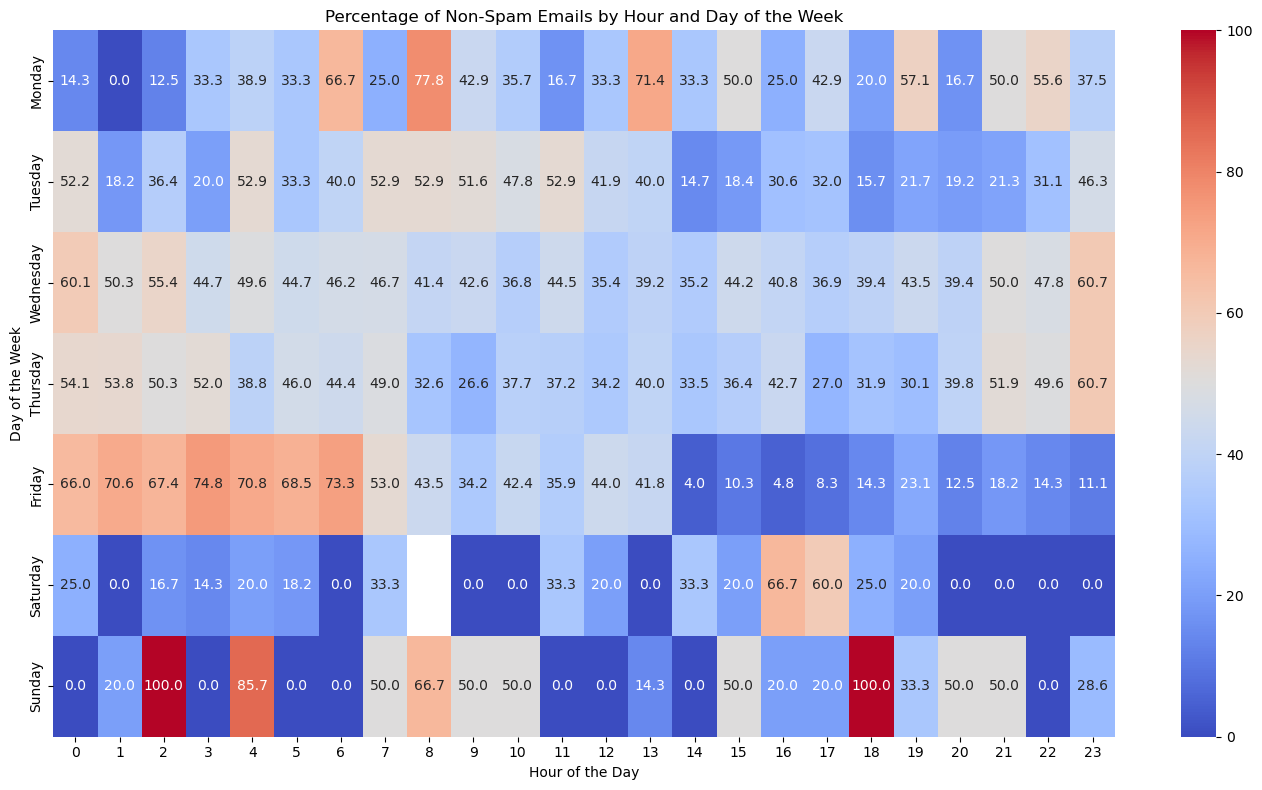

In [24]:
# Ensure 'DAY_NAME' is a categorical type with proper ordering
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DAY_NAME'] = df['DAY_NAME'].astype(pd.CategoricalDtype(categories=day_names, ordered=True))

# Filter for non-spam emails (label == 0)
df_non_spam = df[df['label'] == 0]

# Group by 'HOUR' and 'DAY_NAME' and calculate the percentage of non-spam emails
non_spam_counts = df_non_spam.groupby(['HOUR', 'DAY_NAME']).size()
total_counts = df.groupby(['HOUR', 'DAY_NAME']).size()
percentage_non_spam = (non_spam_counts / total_counts) * 100

# Create a DataFrame for plotting
heatmap_data = pd.DataFrame({
    'HOUR': percentage_non_spam.index.get_level_values('HOUR'),
    'DAY_NAME': percentage_non_spam.index.get_level_values('DAY_NAME'),
    'Percentage_Non_Spam': percentage_non_spam.values
})

# Pivot the data for heatmap
heatmap_pivot = heatmap_data.pivot_table(index='DAY_NAME', columns='HOUR', values='Percentage_Non_Spam')

# Ensure correct ordering of columns and index
heatmap_pivot = heatmap_pivot.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        day_names,
        categories=day_names,
        ordered=True
    )
)

# Plotting
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of Non-Spam Emails by Hour and Day of the Week')

# Show the plot
plt.tight_layout()
plt.show()


This trend is spam emails is relevant because it does not exist in Non-Spam emails.

# Pre-Processing

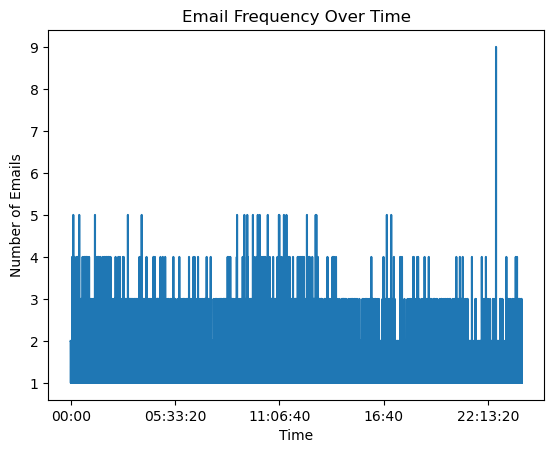

In [25]:
# Plotting the distribution of emails over time
df['Time'].value_counts().sort_index().plot()
plt.title('Email Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Emails')
plt.show()

We see that emails are sent at various times but there is an increased number of emails at 22:13.

In [26]:
# Filter the DataFrame where label is 1
df_phishing = df[df['label'] == 1]

In [27]:
# Find the time with the highest number of phishing emails
time_counts = df_phishing['Time'].value_counts().sort_index()
peak_time = time_counts.idxmax()
peak_count = time_counts.max()
    
print(f"The peak time with {peak_count} emails sent is {peak_time}.")

The peak time with 9 emails sent is 22:38:18.


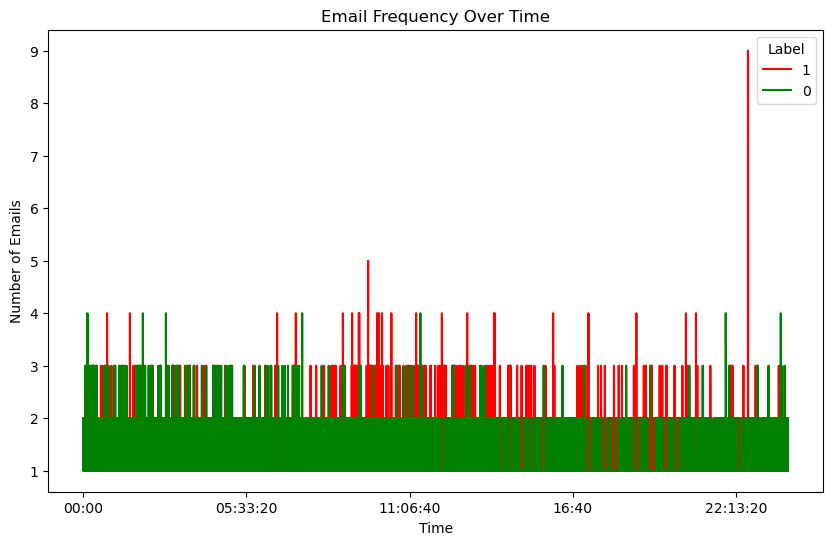

In [28]:
# Assuming 'label' is the column used for coloring
labels = df['label'].unique()

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each label with a different color
colors = ['red', 'green'] 
for i, label in enumerate(labels):
    subset = df[df['label'] == label]
    subset['Time'].value_counts().sort_index().plot(
        kind='line', color=colors[i], label=label)

# Add title and labels
plt.title('Email Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Emails')
plt.legend(title='Label')  

# Show the plot
plt.show()

Most spam emails are sent late at night. We take this trend into consideration and add it to a variable called late that takes a value 1 when it is sent late and 0 otherwise.

## Create sub-set of corpus

In [29]:
# Create a randomized sample of 20% of the data
df_filtered_night = df.sample(frac=0.2, random_state=42)


In [30]:
df_filtered_night.reset_index(drop=True, inplace=True)

## Lemmatization 

In [31]:
# Concatenate 'subject' and 'body' into a new column 'document'
df_filtered_night['document'] = df_filtered_night['subject'] + ' ' + df_filtered_night['body']


In [32]:
# Ensure the 'document' column is of type string
df_filtered_night['document'] = df_filtered_night['document'].astype(str)


Similarly to the authors of the main paper, we now choose to use the TF-IDF on Combined Text Data. This approach will create a TF-IDF matrix based on the combined text from both columns, preserving the relationship between 'body' and 'subject' in the vectorization process.

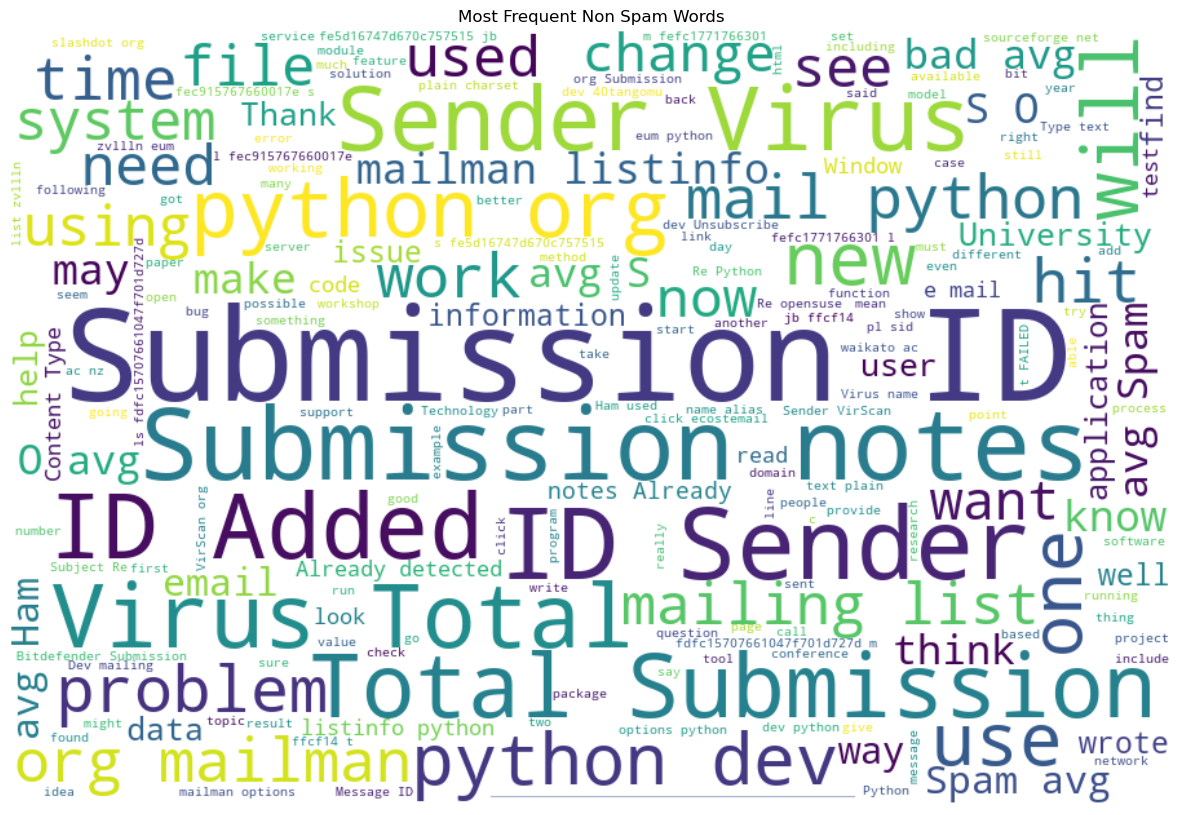

In [33]:
# Plotting word cloud form non spam messages 
ham = " ".join(df_filtered_night[df_filtered_night['label'] == 0]['document'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(ham)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequent Non Spam Words")
plt.show()

For non spam emails, we see that the word cloud contains a lot of extra words, codes, and numbers that do not make a lot of sense. This indicates that the dataset might include noisy or irrelevant data. Steps like removing non-alphabetic characters, filtering out numbers, and handling specific jargon or codes might be necessary to focus on the meaningful content.
However, we see a trend of tech words such as ID, Submission, Sender, Virus, Total, python, dev, mail, mailing, spam... The frequent occurrence of these words suggests that the main themes or subjects revolve around these areas.

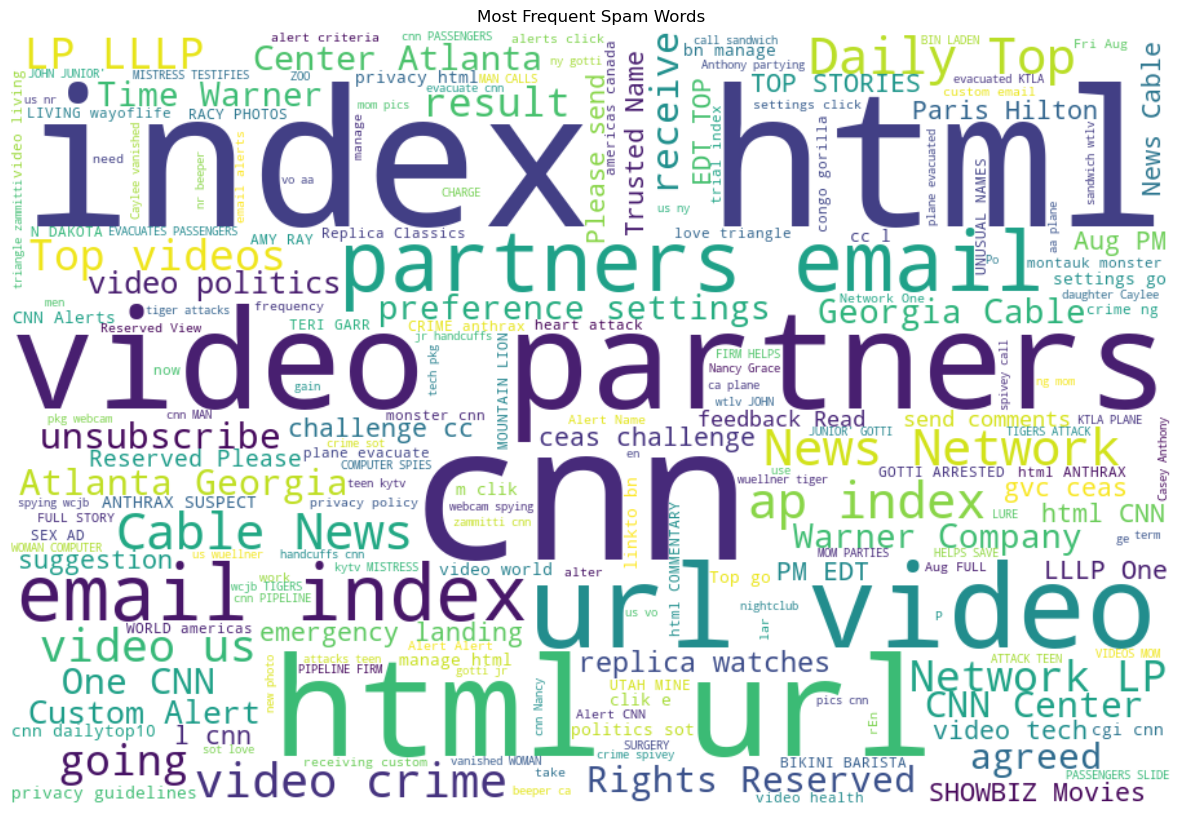

In [34]:
# Plotting word cloud form spam messages 
spam = " ".join(df_filtered_night[df_filtered_night['label'] == 1]['document'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(spam)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequent Spam Words")
plt.show()


For spam words, we get again words that need to go through preprocessing to clean the text. But now the main words in the word cloud are video, url, partners, cnn, network, news, html, daily, unsubscribe, index, trusted, parties... These words indicate that the text likely includes newsletters, promotional content, or phishing emails that are often flagged as spam. Words like "unsubscribe" and "url" are particularly strong indicators of email marketing materials or newsletters.

## Creating Preprocess functions

In [35]:
def expand_contractions(text):
    """
    Function to expand contractions in English text.

    Contractions are shortened versions of words or syllables, often with an apostrophe, 
    such as "don't" for "do not" or "it's" for "it is". This function expands contractions
    in a given text by replacing them with their full forms.

    Parameters:
    text (str): Input text containing contractions.

    Returns:
    str: Text with expanded contractions.
    """
    return " ".join([contractions.fix(word) for word in text.split()])

In [36]:
def clean_text(text):
    """
    Function to clean text data by performing the following steps:
    - Replace newline characters with spaces
    - Remove the string 're'
    
    Parameters:
    text: Input text to be cleaned, can be of any type.
    
    Returns:
    str: Cleaned text.
    """
    # Convert the input to string, regardless of its original type
    text = str(text)
    
    cleaned_text = text.replace('\n', ' ').strip()
    cleaned_text = cleaned_text.replace('re', ' ').strip()
    return cleaned_text

In [37]:
def remove_punctuation(text):
    """
    Function to remove all punctuation marks from a string.
    
    Parameters:
    text (str): Input string from which punctuation will be removed.
    
    Returns:
    str: String without any punctuation marks.
    """
    # Define regex pattern for punctuation marks
    punctuation_pattern = r'[^\w\s]'
    
    # Replace punctuation marks with an empty string
    text = re.sub(punctuation_pattern, '', text)
    
    return text

In [38]:
# Initialize NLTK's stopwords
sw_nltk = set(stopwords.words('english'))

# Define custom stopwords
custom_stopwords = set([
    'com', 'http', 'mail', 'url', 'link', 'web', 'site', 'page', 'domain', 'webpage', 
    'server', 'html', 'www', 'the', 'lm', 'amp', 'pi', 'oo', 'som', 'ti', 'ma', 'li', 
    'er', 'si', 'de', 'mod', 'fa', 'db', 'gnu', 'bin', 'lf', 'ti',
    'fefc1771766301', 'ffcf14', 'jb', 'zvllln', 'fe5d16747d670c757515', 'jr', 
    'lllp', 'wuellner', 'cc', 'aa', 'po', 'vo', 'gotti', 'fri', 'zammitti', 'aug'
])
# Combine NLTK's stopwords with custom stopwords
stop_words = set(sw_nltk).union(custom_stopwords)

In [39]:
def remove_stopwords(text):
    """
    Removes stopwords from the input text.

    Parameters:
    text (str): The input text to be cleaned, provided as a string.

    Returns:
    str: The cleaned text with stopwords removed.
    """
    # Tokenize the input text
    word_tokens = word_tokenize(text.lower())
    # Remove stopwords from the tokenized words
    filtered_words = [word for word in word_tokens if word not in stop_words]

    # Join the filtered words back into a single string
    filtered_text = ' '.join(filtered_words)

    return filtered_text

In [40]:
def remove_numbers(text):
    """
    Removes all numeric digits from the input text.

    Parameters:
    text (str): The input text from which numbers need to be removed.

    Returns:
    str: The text with all numeric digits removed.
    """
    # Use regex to remove all numbers from the text
    cleaned_text = re.sub(r'\d+', '', text)
    return cleaned_text

In [41]:
def remove_extra_spaces(text):
    """
    Removes extra spaces from the input text, ensuring that only single spaces separate words.

    Parameters:
    text (str): The input text from which extra spaces need to be removed.

    Returns:
    str: The text with extra spaces replaced by a single space and leading/trailing spaces removed.
    """
    # Use regex to replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', text).strip()
    return cleaned_text

In [42]:
lemmatizer = WordNetLemmatizer()
# Define your tag dictionary mapping NLTK POS tags to WordNet POS tags
tag_dict = {
    'N': wordnet.NOUN,
    'V': wordnet.VERB,
    'R': wordnet.ADV,
    'J': wordnet.ADJ
}

In [43]:
def lemmatize_sentence(sentence):
    """
    Performs lemmatization on a given sentence, converting words to their base or dictionary form
    based on their part of speech (POS).

    Parameters:
    sentence (str): The input sentence to be lemmatized.

    Returns:
    str: The lemmatized sentence with words in their base form.
    """
    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence)
    
    # Perform POS tagging on the words
    pos_list_of_tuples = nltk.pos_tag(words)
    
    # Initialize an empty list to store lemmatized words
    new_sentence_words = []
    
    # Iterate through each word and its corresponding POS tag
    for word_idx, (word, nltk_word_pos) in enumerate(pos_list_of_tuples):
        # Extract the first character of the NLTK POS tag
        nltk_word_pos_tag = nltk_word_pos[0].upper()
        
        # Check if the first character of the NLTK POS tag exists in tag_dict
        if nltk_word_pos_tag in tag_dict:
            # Get the corresponding WordNet POS tag
            wordnet_word_pos = tag_dict[nltk_word_pos_tag]
            # Lemmatize the word using the WordNet POS tag
            new_word = lemmatizer.lemmatize(word, wordnet_word_pos)
        else:
            # Lemmatize the word without specifying the POS tag
            new_word = lemmatizer.lemmatize(word)
        
        # Append the lemmatized word to the new sentence words list
        new_sentence_words.append(new_word)
    
    # Join the list of words into a new sentence
    new_sentence = " ".join(new_sentence_words)
    
    return new_sentence

In [44]:
def limit_repeated_letters(word):
    """
    Reduces sequences of more than two repeated letters in a word to exactly two occurrences.

    Parameters:
    word (str): The input word to be processed.

    Returns:
    str: The word with any sequence of more than two repeated letters limited to two occurrences.
    """
    # This regular expression will match any sequence of more than two repeated letters
    pattern = re.compile(r'(.)\1{2,}')
    
    # Function to replace sequences of more than two repeated letters with exactly two
    def replace(match):
        char = match.group(1)  # The letter that was repeated
        return char * 2  # Replace with exactly two occurrences of that letter
    
    # Substitute all matches in the word with exactly two letters
    return pattern.sub(replace, word)

In [45]:
# Initialize the mistakes, correct_count and incorrect_count column
df_filtered_night['mistakes'] = 0
df_filtered_night['correct_count'] = 0
df_filtered_night['incorrect_count'] = 0

In [46]:
def process_and_correct(text):
    """
    Processes and corrects the text by limiting repeated letters in words and performing spell-checking.

    Parameters:
    text (str): The input text to be processed and corrected.

    Returns:
    tuple: A tuple containing:
        - corrected_text (str): The text after processing and correcting.
        - mistakes_count (int): The number of words that were corrected.
    """
    spell = Speller(lang='en')
    mistakes_count = 0   
    words = text.split()  # Split the text into words
    corrected_words = []  # To store the corrected words

    for word in words:
        # Apply the limit_repeated_letters function and then correct the word
        corrected_word = spell(limit_repeated_letters(word))
        
        # Check if the word was corrected
        if corrected_word != word:
            mistakes_count += 1
        
        # Add the corrected word to the list
        corrected_words.append(corrected_word)
    
    # Join the corrected words into a single string
    corrected_text = ' '.join(corrected_words)
    
    return corrected_text, mistakes_count

In [47]:
def remove_single_letters(sentence):
    """
    Removes single-letter words from a given sentence.

    Parameters:
    sentence (str): The input sentence to be cleaned.

    Returns:
    str: The sentence after removing any single-letter words.
    """
    # Split the sentence into words
    words = sentence.split()
    
    # Filter out single-letter words
    filtered_words = [word for word in words if len(word) > 1]
    
    # Join the remaining words back into a sentence
    cleaned_sentence = ' '.join(filtered_words)
    
    return cleaned_sentence

In [48]:
def remove_punctuation(text):
    """
    Removes all punctuation from the given text.

    Parameters:
    text (str): The input string from which punctuation will be removed.

    Returns:
    str: The input string with all punctuation characters removed.
    """
    return text.translate(str.maketrans('', '', string.punctuation))

In [49]:
def pos_tag_text(text):
    """
    Perform Part-of-Speech (POS) tagging on the given text and return a list of tuples where each tuple contains a word and its corresponding POS tag.

    Parameters:
    text (str): The input string to be tokenized and tagged.

    Returns:
    list of tuples: A list where each tuple consists of a word from the input text and its associated POS tag.
    """
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Perform POS tagging on the words
    pos_list_of_tuples = nltk.pos_tag(words)
    
    return pos_list_of_tuples

In [50]:
def check_sentence(sentence):
    """
    Check the spelling of words in the given sentence, remove single-letter words and extra spaces, and return a cleaned sentence along with counts of correct and incorrect words.

    Parameters:
    sentence (str): The input sentence to be checked for spelling and cleaned.

    Returns:
    tuple: A tuple containing:
        - cleaned_sentence (str): The sentence with single-letter words and misspelled words removed, and extra spaces cleaned.
        - correct_count (int): The number of correctly spelled words in the original sentence.
        - incorrect_count (int): The number of misspelled words in the original sentence.
    """
    # Initialize the SpellChecker object
    spell = SpellChecker()

    # First, remove single-letter words from the sentence
    sentence = remove_single_letters(sentence)
    
    # Split the sentence into words
    words = sentence.split()
    
    # Initialize counts and lists for correct and incorrect words
    correct_count = 0
    incorrect_count = 0
    corrected_words = []
    
    # Process each word
    for word in words:
        # Check if the word exists in the dictionary
        if word.lower() in spell:
            correct_count += 1
            corrected_words.append(word)
        else:
            incorrect_count += 1

    # Join the correct words into a cleaned sentence
    cleaned_sentence = ' '.join(corrected_words)

    #Remove extra spaces
    cleaned_sentence = remove_extra_spaces(cleaned_sentence)
    
    return cleaned_sentence, correct_count, incorrect_count

In [51]:
def preprocess_text(text):
    """
    Preprocess the input text by performing several cleaning and normalization steps, including:
    - Convert text to lowercase
    - Clean text
    - Expand contractions
    - Remove HTML tags
    - Replace diacritics (accented characters) with nearest characters
    - Replace dots with spaces
    - Remove non-alphanumeric characters
    - Remove digits
    - Remove stopwords
    - Remove punctuation marks
    - Tokenize the text
    - Perform Part-of-Speech (POS) tagging
    - Lemmatize each word based on its POS tag
    - Correct typos using a typo correction function
    
    Parameters:
    text (str): The input text to be preprocessed.
    
    Returns:
    tuple: A tuple containing:
        - cleaned_sentence (str): The final preprocessed text with corrections applied.
        - mistakes_count (int): The number of spelling mistakes found and corrected.
        - correct_count (int): The number of correctly spelled words in the cleaned sentence.
        - incorrect_count (int): The number of misspelled words in the cleaned sentence.
    """
    # Convert text to lowercase
    text = text.lower()
    
    # Clean text
    text = clean_text(text)

    # Expand contractions
    text = expand_contractions(text)
    
    # Remove HTML tags (if any)
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Replace diacritics (accented characters) with nearest characters
    text = unidecode(text, errors="preserve")
    
    # Replace dots with spaces
    text = re.sub(r'\.', ' ', text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    
    # Remove digits
    text = remove_numbers(text)
    
    # Remove stopwords
    text = remove_stopwords(text)
    
    # Remove punctuation marks
    text = remove_punctuation(text)
    
    # Perform POS tagging on the words
    pos_list_of_tuples = pos_tag_text(text)
    
    # Lemmatize each word based on its POS tag
    lemmatized_words = []
    for word, nltk_word_pos in pos_list_of_tuples:
        nltk_word_pos_tag = nltk_word_pos[0].upper()
        if nltk_word_pos_tag in tag_dict:
            wordnet_word_pos = tag_dict[nltk_word_pos_tag]
            lemmatized_word = lemmatizer.lemmatize(word, wordnet_word_pos)
        else:
            lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemmatized_word)
    
    # Join the lemmatized words back into a single string
    lemmatized_text = ' '.join(lemmatized_words)

    # Remove extra spaces
    lemmatized_text = re.sub(r'\s+', ' ', lemmatized_text).strip()

    # Use regex to remove standalone letters (with spaces before and after)
    lemmatized_text = re.sub(r'\b[a-zA-Z]\b', '', lemmatized_text)

    # Convert text to lowercase
    lemmatized_text = lemmatized_text.lower()
    
    # Correct typos 
    corrected_text, mistakes_count = process_and_correct(lemmatized_text)

    #Check how many still makes sense
    cleaned_sentence, correct_count, incorrect_count = check_sentence(corrected_text)

    return cleaned_sentence, mistakes_count, correct_count, incorrect_count


In [52]:
#Using the function on our data:
df_filtered_night[['cleaned_document', 'mistakes','correct_count','incorrect_count']] = df_filtered_night['document'].apply(lambda text: pd.Series(preprocess_text(text)))

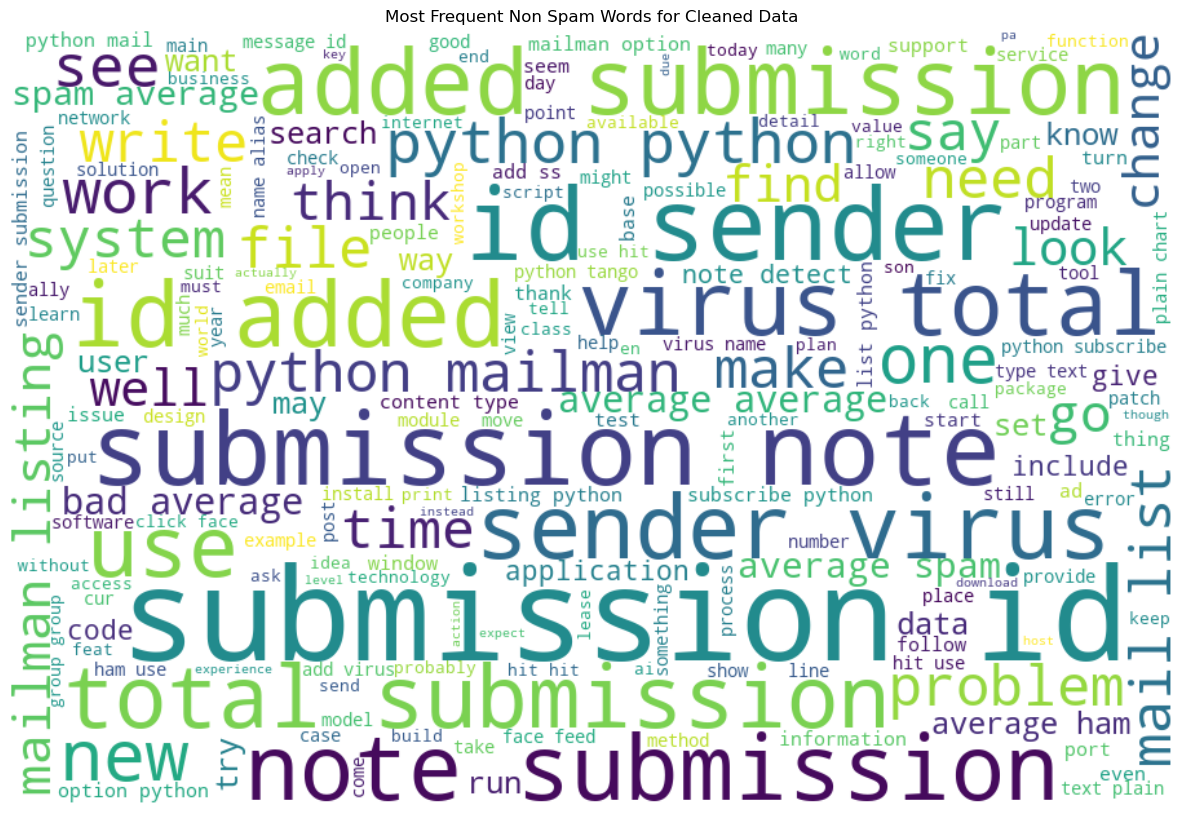

In [53]:
# Plotting word cloud form non spam messages  after cleaning
ham = " ".join(df_filtered_night[df_filtered_night['label'] == 0]['cleaned_document'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(ham)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequent Non Spam Words for Cleaned Data")
plt.show()

After cleaning the data, the word cloud for non spam words no longer shows noisiness in the dataset. We see that the main words are submission, total, python, listing, virus, total, id, sender, note... Our dataset involves various types of content, potentially related to email or document processing.

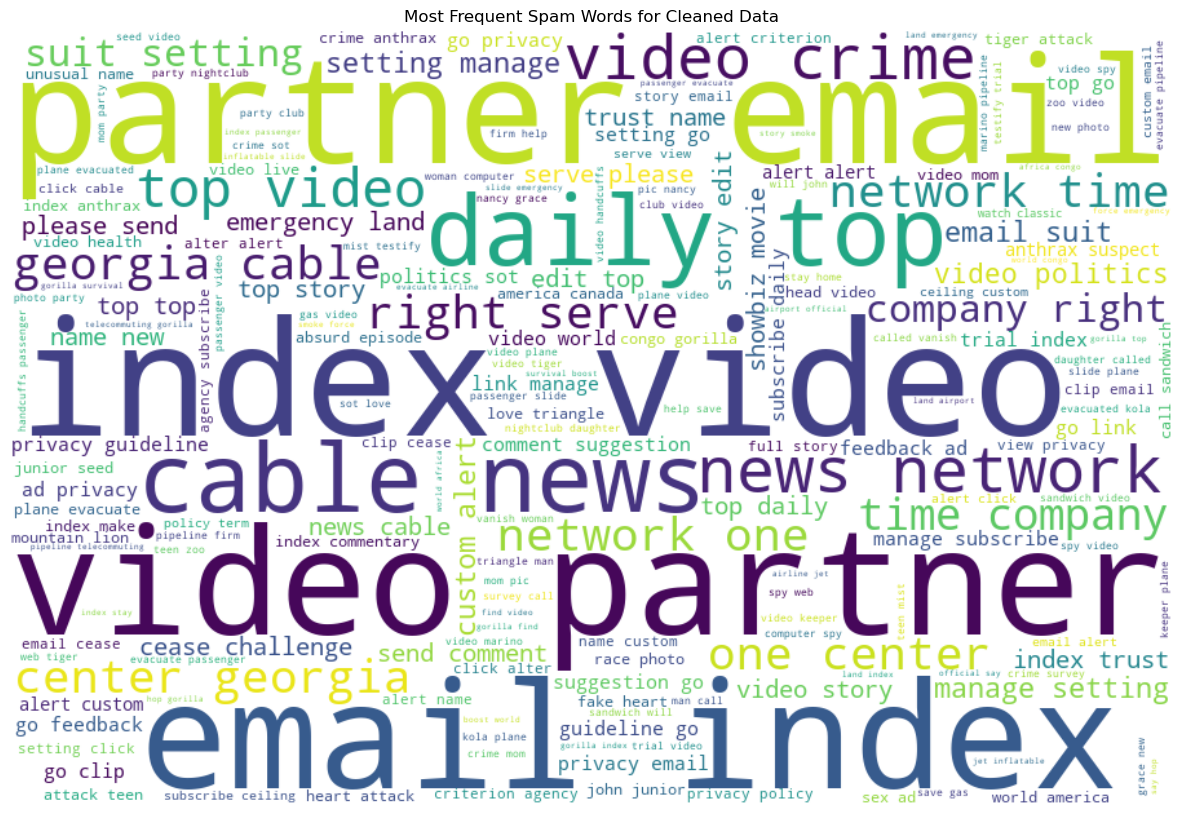

In [54]:
# Plotting word cloud form spam messages after cleaning 
spam = " ".join(df_filtered_night[df_filtered_night['label'] == 1]['cleaned_document'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(spam)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequent Spam Words for Cleaned Data")
plt.show()

For spam emails, on the other hand, the main words are email, index, video, parter, news, network, daily, top, georgia, center, crime, cable, time... Words like Email, Video, News might indicate promotional content or content designed to capture attention, which might push users into clicking links or viewing media. The term partner may be used to create a sense of legitimacy or to refer to organizations or businesses. Other words are also common in spam emails such as: Index, Network, Daily, Top, wich give an impression of valuable or curated information.

# Main code

# Method

## Latent Semantic Analysis
##### LSA helps in retrieving relevant documents based on semantic similarity rather than just keyword matching.

In [55]:
# Define the parameters for TfidfVectorizer
tfidf = TfidfVectorizer(
    lowercase=False,    # Do not convert words to lowercase
    stop_words=None,    # Do not remove any stop words
    ngram_range=(1, 1),  # Use unigrams (single words)
    max_df=0.99,         # Ignore terms that appear in more than 99% of documents
    min_df=0.01          # Ignore terms that appear in less than 1% of documents
)

In [56]:
# Fit and transform the text data
tfidf_train_sparse = tfidf.fit_transform(df_filtered_night['cleaned_document'])

We now convert the TF-IDF transformed data into a a pandas DataFrame The columns of the DataFrame are set to the feature names learned by TfidfVectorizer, which represent the vocabulary of the text data after TF-IDF transformation. Each row represents a document and each column represents a term weighted by its TF-IDF value.

In [57]:
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf.get_feature_names_out())

We now create an lsa_obj which is used to transform the TF-IDF matrix into a lower-dimensional space (10 dimensions in this case) using Truncated SVD. This transformed representation retains the most important information about the relationship between terms and documents while reducing noise and computational complexity

In [58]:
#Creating lsa_obj
lsa_obj = TruncatedSVD(n_components=10, n_iter=10000, random_state=seed)

This is a crucial step in performing Latent Semantic Analysis (LSA) on text data.
The reduced-dimensional representation can improve the performance of classifiers by reducing the curse of dimensionality and focusing on the most informative features.

We compute the matrix multiplication of the TF-IDF matrix (tfidf_train_df) with the matrix of right singular vectors (V_T) extracted from TruncatedSVD (lsa_obj). It transforms tfidf_train_df into a lower-dimensional representation (tfidf_lsa_data) that captures the underlying topics or concepts in the text data. The reduced representation (tfidf_lsa_data) can be used to measure similarity between documents based on their topics rather than exact word matches.

In [59]:
#Transforming the TF-IDF matrix into the reduced space
tfidf_lsa_data= lsa_obj.fit_transform(tfidf_train_df)

We first retrieve the singular values (Sigma and V_T) obtained during the SVD computation. Singular values indicate the importance or strength of each latent concept (or topic) represented by the components. Larger values indicate more significant topics or concepts in the dataset. In other words, topics with higher singular values explain more variance in the original TF-IDF matrix.
Each row of V_T represents a topic (or latent concept) and each column represents a term from the original TF-IDF matrix.The values in V_T show the importance (or weight) of each term in each topic. Each row (V_T[i]) represents a topic.  Positive values indicate positive correlation with terms, implying those terms are important in defining that topic. Negative values suggest an inverse relationship.

In [60]:
# Extract singular values (Sigma) and right singular vectors (V_T)
Sigma= lsa_obj.singular_values_
V_T = lsa_obj.components_.T

We then create an LSA DataFrame will have rows corresponding to documents and columns corresponding to latent concepts or topics identified by LSA.

In [61]:
lsa = pd.DataFrame(data=tfidf_lsa_data, columns=[f'Latent_concept_{r}' for r in range (0,len(tfidf_lsa_data[1]))])

We now print the dataframe. Each column (Latent_concept_0, Latent_concept_1, ..., up to Latent_concept_n-1) represents a latent concept.  The values in these columns indicate the strength or relevance of each concept in each document. 

In [62]:
lsa

Latent_concept_0  Latent_concept_1  Latent_concept_2  Latent_concept_3  \
0             0.035114          0.104566          0.086852          0.655237   
1             0.118174          0.103865          0.034633          0.025526   
2             0.036357          0.085485          0.053991          0.380650   
3             0.051014          0.113119          0.057240          0.040871   
4             0.040723          0.102258          0.012697          0.031468   
...                ...               ...               ...               ...   
7823          0.023070          0.054218          0.011101          0.052618   
7824          0.073974          0.725761         -0.156771         -0.167310   
7825          0.060917          0.396707         -0.060058         -0.037811   
7826          0.006355          0.025574          0.003231          0.020054   
7827          0.032511          0.087835          0.079291          0.684424   

      Latent_concept_4  Latent_concept_5  Latent_concept_6  Latent_concept_7  \
0            -0.168816          0.051529         -0.065397          0.006021   
1             0.134376         -0.071648         -0.078178         -0.034351   
2            -0.063390         -0.013360         -0.016687          0.007596   
3             0.190148         -0.084006         -0.046209         -0.006902   
4             0.166250          0.013293         -0.049342         -0.005185   
...                ...               ...               ...               ...   
7823          0.085745         -0.029586          0.084356          0.016402   
7824         -0.282554          0.044695          0.028232         -0.005018   
7825          0.013737         -0.046462         -0.042368          0.006106   
7826          0.041366         -0.029505          0.016212          0.016728   
7827         -0.219795         -0.007991         -0.033651          0.007663   

      Latent_concept_8  Latent_concept_9  
0            -0.028686         -0.050263  
1            -0.104971          0.015642  
2            -0.013674          0.014799  
3             0.248243         -0.101125  
4             0.293106         -0.141250  
...                ...               ...  
7823          0.021046          0.092684  
7824          0.034599          0.008508  
7825         -0.028304          0.003400  
7826         -0.006358          0.139130  
7827         -0.013371         -0.056809  

[7828 rows x 10 columns]

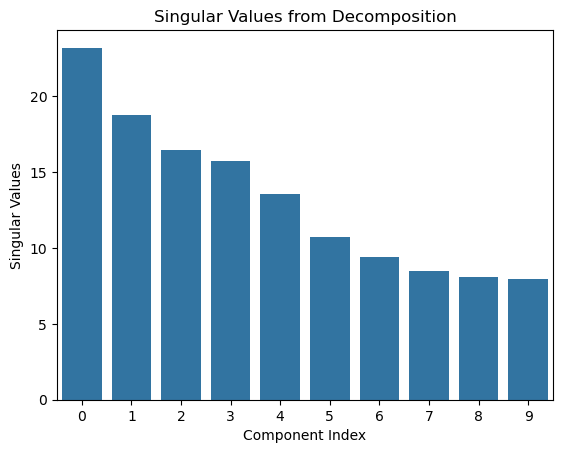

In [63]:
#Plotting to visualize the distribution or magnitude of the singular values (Sigma) derived from the decomposition process.
sns.barplot(x=list(range(len(Sigma))), y=Sigma)
plt.xlabel('Component Index')
plt.ylabel('Singular Values')
plt.title('Singular Values from Decomposition')
plt.show()

We see that the first singular values is larger than the rest. This indicates that one of the components (corresponding to that singular values) is sufficient to capture most of the variability in our dataset. On the other hand, the 8 following singular values are also relatively important in magnitude, it suggests that more components are needed to effectively represent the dataset.

We now construct a Pandas DataFrame called term_concept_matrix from the given data V_T. It transposes the matrix of singular vectors obtained from the matrix decomposition technique. It provides a structured representation of how terms (features) are associated with each latent concept (topic) derived from the matrix decomposition.

In [64]:
# Creating term_concept_matrix transposed dataframe from V_T values
term_concept_matrix = pd.DataFrame(data=V_T, 
                                 index = tfidf.get_feature_names_out(), #terms N 792
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])]) #topics 20

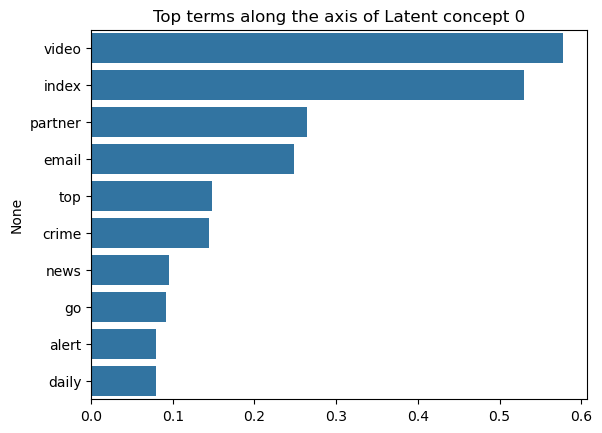

In [65]:
# Extracting the latent concept (topic) 0 from the term_concept_matrix
latent_concept = term_concept_matrix['Latent_concept_0']

# Sorting the latent concept by values in descending order to find the most significant terms
latent_concept = latent_concept.sort_values(ascending=False)

# Selecting the top 10 terms that contribute the most to latent concept 0
top_10 = latent_concept[:10]

# Plotting the top 10 terms contributing to latent concept 0 using a bar plot
plt.title('Top terms along the axis of Latent concept 0')
fig = sns.barplot(x=top_10.values, y=top_10.index)


#### The top term in Latent Concept 0 is video, followed by index, partner, email, top, crime, news, go, alert, and daily. 
- Video: Spam emails often contain references to video content, which could be used to lure recipients into clicking on malicious links or downloading harmful files. This term suggests that many spam emails in this latent concept might be using video content as bait.
- Index: The term "index" might refer to search engines, databases, or listings. In spam, this could be used in the context of promoting fake services, websites, or directories.
- Partner: Spam emails often mention "partners" or "partnerships" to give the illusion of legitimacy or to falsely imply that the email is from a trusted entity or associated with a known brand.
- Email: The presence of the word "email" might indicate that these spam messages are discussing email services, fake email notifications, or phishing attempts where the spammer is attempting to collect email addresses or sensitive information.
- Top: The word "top" could be used to convey a sense of urgency or importance, often seen in spam subject lines like "Top News", "Top Deals", or "Top Opportunities", which are designed to catch the recipient's attention.
- Crime: The mention of "crime" might relate to spam emails discussing crime-related news or fake alerts, often used to scare recipients into taking immediate action, such as clicking a link or opening an attachment.
- News: "News" in spam emails could refer to fake news stories or sensational headlines designed to attract clicks. Spammers may exploit trending news topics to make their messages seem timely and relevant.
- Go: The term "go" might be used in call-to-action phrases such as "Go to this site", "Go here", or "Go now", which are common in spam emails trying to direct recipients to malicious websites.
- Alert: "Alert" suggests that the spam emails could be posing as security alerts, financial alerts, or other notifications meant to alarm the recipient into taking immediate action, which is a common tactic in phishing scams.
- Daily: The use of "daily" could imply a recurring message, such as daily deals, daily news, or daily alerts, often seen in promotional spam or subscription-based spam emails that aim to bombard the recipient with frequent messages.

# Feature Creation

In [67]:
# Creating new features based on keyword presence: counting how many times these words are present
df_filtered_night['contains_video'] = df_filtered_night['cleaned_document'].str.contains(r'\bvideo\b', case=False).astype(int)
df_filtered_night['contains_crime'] = df_filtered_night['cleaned_document'].str.contains(r'\bcrime\b', case=False).astype(int)
df_filtered_night['contains_index'] = df_filtered_night['cleaned_document'].str.contains(r'\bindex\b', case=False).astype(int)
df_filtered_night['contains_news'] = df_filtered_night['cleaned_document'].str.contains(r'\bnews\b', case=False).astype(int)
df_filtered_night['contains_alert'] = df_filtered_night['cleaned_document'].str.contains(r'\balert\b', case=False).astype(int)

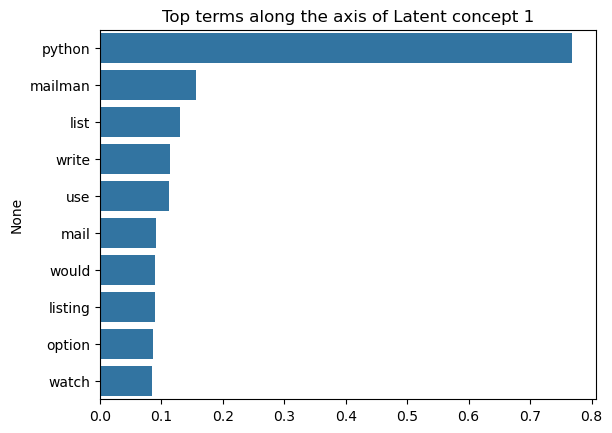

In [69]:
# Extracting the latent concept (topic) 1 from the term_concept_matrix
latent_concept = term_concept_matrix['Latent_concept_1']

# Sorting the latent concept by values in descending order to find the most significant terms
latent_concept = latent_concept.sort_values(ascending=False)

# Selecting the top 10 terms that contribute the most to latent concept 1
top_10 = latent_concept[:10]

# Plotting the top 10 terms contributing to latent concept 1 using a bar plot
plt.title('Top terms along the axis of Latent concept 1')
fig = sns.barplot(x=top_10.values, y=top_10.index)

As the latent concept 1 also explains a lot of the data, we delved deeper into it and decided to add the variable python to our list.

In [71]:
# Creating new features based on keyword presence: counting how many times these words are present
df_filtered_night['contains_python'] = df_filtered_night['cleaned_document'].str.contains(r'\bpython\b', case=False).astype(int)

In [72]:
#We now add a new column named 'token' to the DataFrame term_concept_matrix
term_concept_matrix['token'] = term_concept_matrix.index

This new column 'token' will contain the same values as the index of term_concept_matrix.

In [73]:
print(term_concept_matrix)

            Latent_concept_0  Latent_concept_1  Latent_concept_2  \
ability             0.000860          0.003861          0.000460   
able                0.003229          0.016703          0.000240   
absolutely          0.001451          0.005358          0.001447   
abstract            0.000648          0.002683          0.000488   
absurd              0.022962         -0.005027         -0.004792   
...                      ...               ...               ...   
yes                 0.003615          0.019209          0.000284   
yet                 0.002558          0.012410          0.000019   
york                0.002879          0.004172          0.002717   
young               0.001558          0.003202          0.002484   
zoo                 0.012465         -0.002613         -0.002646   

            Latent_concept_3  Latent_concept_4  Latent_concept_5  \
ability             0.000740          0.005145         -0.002868   
able                0.003569          0.019762 

In [74]:
term_concept_matrix = term_concept_matrix.drop('token', axis=1)

### Latent Dirichlet Allocation 

We both did LSA and LSD because LSA attempts to discover the underlying relationships between words, whereas LDA seeks to discover the underlying topics in a corpus of text. And we wanted to examine both.

#### Get document topics function

In [75]:
def get_document_topics_matrix(statements, num_topics, corpus, model):
    
    """
    Generate a document-to-topic matrix for a given set of documents based on a topic model.

    Parameters:
    statements (list of str): A list of documents or text statements for which topics are to be identified.
    num_topics (int): The number of topics in the topic model.
    corpus (list of list of (int, int)): The corpus in the form of a bag-of-words, where each document is represented as a list of (word_id, word_frequency) tuples.
    model (gensim.models.ldamodel.LdaModel): A trained LDA (Latent Dirichlet Allocation) model used to infer topics for the given corpus.

    Returns:
    pd.DataFrame: A DataFrame where each row corresponds to a document and each column (topic_1, topic_2, ..., topic_n) represents the contribution of that topic to the document. The values in the DataFrame are the topic probabilities for each document.
    """
    
    get_document_topics = [model.get_document_topics(item) for item in corpus]
    
    document_topics = pd.DataFrame(columns=['topic_' + str(i) for i in range(1,num_topics+1)],index=range(0,len(statements)))

    d=0
    g=0
    for r in range(0, len(statements)):
        if statements[r]!="":
            document_topics[d:(d+1)] = 0
            for t in (range(0, len(get_document_topics[g]))):
                document_topics.loc[(r):(r),str("topic_"+str((get_document_topics[g][t][0]+1)))]=get_document_topics[g][t][1]  
            g=g+1

        d=d+1
    
    return document_topics

#### Training function

In [76]:
def train_lda_model(statements, num_topics, trim):
    """
    Train a Latent Dirichlet Allocation (LDA) model on the provided set of statements.

    This function processes the input text data, constructs a dictionary and a corpus,
    and then trains an LDA model to identify latent topics in the text data.

    Parameters:
    statements (list of str): A list of text statements or documents to be used for training the LDA model.
    num_topics (int): The number of topics to generate in the LDA model.
    trim (float): The threshold for filtering out tokens that are too common. Tokens that appear in more than `trim` proportion of documents are removed.

    Returns:
    tuple: A tuple containing:
        - model (gensim.models.ldamodel.LdaModel): The trained LDA model.
        - corpus (list of list of (int, int)): The corpus in bag-of-words format, where each document is represented as a list of (word_id, word_frequency) tuples.
        - id2word (dict): A mapping from word IDs to words, corresponding to the dictionary used in the model.
    """
    
    docs = []
    for statement in statements:
        doc = nlp(statement)
        tokens = [t.text.lower() for t in doc]
        
        if tokens:
            docs.append(tokens)
    
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=10, no_above=trim)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    temp = dictionary[0]
    id2word = dictionary.id2token
    
    chunksize = 1500
    passes = 100
    iterations = 1000
    eval_every = None
    
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state = seed
    )
    
    
    return model, corpus, id2word

#### Elbow curve function

In [77]:
def elbow_topics(statements, maxnumber_topics, trim):
    """
    Determine the optimal number of topics for Latent Dirichlet Allocation (LDA) using the elbow method.

    This function trains multiple LDA models with different numbers of topics and evaluates each model's performance
    using coherence and perplexity scores. The goal is to find the number of topics that yields the best balance
    between model interpretability and performance, typically visualized as the "elbow" in the plot of these scores.

    Parameters:
    statements (list of str): A list of text statements or documents to be used for training the LDA models.
    maxnumber_topics (int): The maximum number of topics to consider when training LDA models.
    trim (float): The threshold for filtering out tokens that are too common across the documents.

    Returns:
    pd.DataFrame: A DataFrame with two columns:
        - 'Coherence': The negative coherence scores for each model (higher is better).
        - 'Topics': The corresponding number of topics used in each model.

    The function also prints perplexity and coherence scores for each model, and plots these scores against the number
    of topics to help identify the optimal number of topics.

    The elbow point, where the rate of improvement slows, can guide the selection of the optimal number of topics.
    """
    
    number_topics = range(1, maxnumber_topics + 1) 
    
    model_topics = [train_lda_model(statements, num_topics = i, trim = trim)[0] for i in number_topics]
    corpus_topics = [train_lda_model(statements, num_topics = i, trim = trim)[1] for i in number_topics]
    
    perplexityscores = [model_topics[i].log_perplexity(corpus_topics[i]) for i in range(len(model_topics))]
    coherencescores = [CoherenceModel(model=model_topics[i], corpus=corpus_topics[i], coherence='u_mass',topn = 10).get_coherence() for i in range(len(model_topics))]
    
    return pd.concat([pd.DataFrame({'Coherence': coherencescores})*(-1), pd.DataFrame({'Topics': range(1, maxnumber_topics + 1)})], axis=1) 
    
    print(perplexityscores)
    print(coherencescores)    
    
    plt.locator_params(axis='y', nbins=12)
    plt.locator_params(axis='x', nbins=maxnumber_topics + 1)
    
    plt.plot(number_topics, coherencescores)
    plt.xlabel('Number of Topics')
    plt.ylabel('coherencescores')
    plt.title('Coherence Score')
    plt.show()
    
    plt.plot(number_topics, perplexityscores)
    plt.xlabel('Number of Topics')
    plt.ylabel('perplexityscores')
    plt.title('Perplexity Score')
    plt.show()

    return result_df


#### Differences between topics

In [78]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """
    Plot the difference matrix between topics using Matplotlib.

    This function visualizes the differences between topics in an LDA model by displaying a heatmap
    of the difference matrix. The heatmap provides insight into how distinct or similar the topics are
    based on the matrix values.

    Parameters:
    mdiff (numpy.ndarray): A 2D array (matrix) representing the differences between topics. 
                           Typically, this matrix contains pairwise differences in terms of topic distributions or word usage.
    title (str): An optional title for the plot. Defaults to an empty string.
    annotation (str, optional): Not used in this function but can be included for future customization, such as adding text annotations to the heatmap.

    Returns:
    None: The function directly creates and saves a plot to a PDF file named "Figure_LDATopicDifferences{n}.pdf", 
          where {n} is the number of topics (size of the matrix).
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    data = ax.imshow(mdiff, cmap='RdBu', origin='lower')
    plt.title(title)
    plt.colorbar(data)
    
    topic = topic = ["{}".format(i) for i in range(1, len(mdiff)+1)]
    ax.set_xticks(np.arange(len(topic)), labels=topic)
    ax.set_yticks(np.arange(len(topic)), labels=topic)
    
    ax.set_xlabel('Topic')
    ax.set_ylabel('Topic')
    
    plt.savefig("Figure_LDATopicDifferences"+ str(len(mdiff)) + ".pdf", bbox_inches='tight', dpi=300)


#### Posterior probability of tokens per topics

In [79]:
def tokens_per_topics(model):
    """
    Retrieve the posterior probabilities of tokens (words) for each topic from a trained LDA model.

    This function extracts the words associated with each topic and their corresponding probabilities (weights)
    from a trained Latent Dirichlet Allocation (LDA) model. The result is a DataFrame that shows which words
    are most strongly associated with each topic.

    Parameters:
    model (LdaModel): The trained LDA model from which the topic-word distributions will be extracted.

    Returns:
    pd.DataFrame: A DataFrame with the following columns:
        - 'word': The token (word) from the model's vocabulary.
        - 'topic': The topic index to which the word's probability is associated.
        - 'probability': The posterior probability (weight) of the word in the given topic.
    """   
    topics = model.show_topics(formatted=False)
    
    
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight])
    
    
    return pd.DataFrame(out, columns=['word', 'topic', 'probability'])  

#### Main

In [80]:
#Define the trim parameter
trim_num = 0.95

In [81]:
#Calculate the coherence score
coherence_score = elbow_topics(df_filtered_night['cleaned_document'], maxnumber_topics = 10, trim = trim_num)

In [82]:
start = 2  # Starting number of topics
limit = 15  # Ending number of topics
step = 1  # Step size

In [83]:
#set the number of topics
true_k = 5

In [84]:
#Train model
model, corpus, id2word = train_lda_model(statements = df_filtered_night['cleaned_document'], num_topics = true_k, trim = trim_num)

In [85]:
# print the keywords per topic
pprint(model.print_topics(num_words=10))

[(0,
  '0.095*"video" + 0.085*"index" + 0.050*"email" + 0.042*"partner" + '
  '0.026*"top" + 0.022*"crime" + 0.017*"go" + 0.014*"news" + 0.013*"daily" + '
  '0.010*"world"'),
 (1,
  '0.044*"python" + 0.011*"watch" + 0.007*"click" + 0.007*"new" + 0.007*"get" '
  '+ 0.006*"make" + 0.006*"time" + 0.006*"take" + 0.005*"offer" + '
  '0.005*"product"'),
 (2,
  '0.124*"submission" + 0.091*"d" + 0.091*"i" + 0.047*"sender" + 0.046*"note" '
  '+ 0.044*"virus" + 0.037*"added" + 0.036*"total" + 0.033*"alert" + '
  '0.015*"custom"'),
 (3,
  '0.012*"use" + 0.011*"list" + 0.011*"write" + 0.011*"message" + '
  '0.008*"would" + 0.007*"file" + 0.006*"get" + 0.005*"ad" + 0.005*"user" + '
  '0.005*"net"'),
 (4,
  '0.065*"average" + 0.029*"hit" + 0.028*"use" + 0.025*"spam" + 0.024*"bad" + '
  '0.022*"ham" + 0.019*"university" + 0.014*"paper" + 0.011*"system" + '
  '0.009*"search"')]


- Topic 0: Dominated by terms like "video," "index," and "email," suggesting this topic might focus on media content, possibly related to emails or communication about videos and indexed content. Other terms like "partner," "crime," and "news" indicate that this topic may also cover partnerships, crime reports, and news.
- Topic 1: Features words such as "python," "watch," and "click," which likely indicate a focus on programming, particularly Python, and potentially instructional content or tutorials. Other terms like "new," "get," and "product" suggest some content related to new products or offerings, possibly in a tech or software context.
- Topic 2: Predominantly features the word "submission," along with "sender," "note," and "virus," indicating this topic could be about the process of submitting forms or documents, potentially with a focus on alerts, warnings, or antivirus-related content.
- Topic 3: Has a more even distribution among terms like "use," "list," and "write," suggesting a general topic related to user activity, communication (messages), and possibly file handling. The presence of "net" and "ad" could indicate topics related to network use or advertisements.
- Topic 4: Centers around words like "average," "hit," and "use," which might point to a statistical or analytical focus, possibly in the context of evaluating performance (e.g., spam vs. ham emails). The mention of "university" and "paper" suggests academic content, while "system" and "search" indicate a possible link to information retrieval systems or educational resources.

### Similar results to the LSA so we do not create any new features, bu this confirms the integrity of previous results. 

We now get document topics from the model and then plot the differences between the topics.

In [86]:
tokens_per_topics_probability = tokens_per_topics(model)

In [87]:
document_topics = get_document_topics_matrix(statements = df_filtered_night['cleaned_document'], num_topics = true_k, corpus = corpus, model = model)
pprint(document_topics)

      topic_1   topic_2   topic_3   topic_4   topic_5
0           0  0.978096         0  0.012544         0
1     0.12966  0.214119         0  0.651604         0
2           0  0.985956         0         0         0
3           0  0.059052         0  0.168133  0.772237
4           0  0.032633         0  0.093598  0.873191
...       ...       ...       ...       ...       ...
7823        0  0.987249         0         0         0
7824        0  0.324649  0.022551  0.651266         0
7825        0  0.168229         0  0.830318         0
7826        0  0.963404         0  0.020981         0
7827        0  0.982353         0    0.0101         0

[7828 rows x 5 columns]


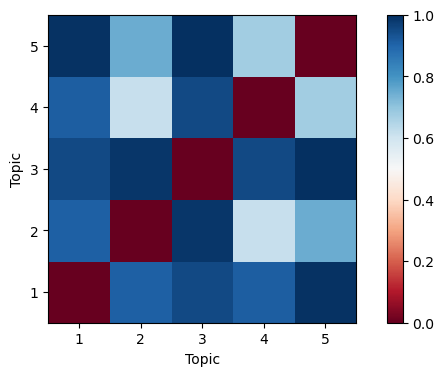

In [88]:
#Plot differences between topics
mdiff, annotation = model.diff(model, distance='jensen_shannon', num_words=10)
plot_difference_matplotlib(mdiff, title="", annotation=annotation)

All the topics are NOT correlated which means we did pick the right number of topics and we do not need to reduce them.

# Sentiment Analysis

## Transformers with Bert for Sentiment Analysis

In [89]:
#Creating the sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis",
                              model="distilbert-base-uncased-finetuned-sst-2-english",
                              framework="tf") 

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [90]:
def sentiment_analysis(text):
    """
    Perform sentiment analysis on the given text and return the probabilities for positive, neutral, and negative sentiments.

    This function uses a pre-trained sentiment analysis pipeline to evaluate the sentiment of the input text. 
    The output is a dictionary containing the probabilities for each sentiment class: positive, neutral, and negative. 
    The function ensures that the sentiment scores are correctly mapped to these classes, with a particular focus on positive sentiment.

    Parameters:
    text (str): The input text on which sentiment analysis is performed.

    Returns:
    dict: A dictionary with keys 'positive', 'neutral', and 'negative', and their corresponding probability scores as values.
    """
    # Get the sentiment analysis results
    results = sentiment_pipeline(text)
    
    # Initialize a dictionary to store probabilities. Note, in the model, the focus is on the positive sentiment.
    sentiment_probabilities = {"positive": 0.0, "neutral": 0.0, "negative": 0.0}
    
    # Map the results to our dictionary
    for result in results:
        label = result['label'].lower()
        if label == 'positive':
            sentiment_probabilities['positive'] = result['score']
        elif label == 'negative':
            sentiment_probabilities['negative'] = result['score']
        else:
            sentiment_probabilities['neutral'] = result['score']    
    
    return sentiment_probabilities

In [91]:
def sentiment_analysis_english(statements):
    """
    Analyze the sentiment of multiple statements and return a DataFrame with sentiment probabilities.

    This function applies sentiment analysis to each statement in the provided list, computing the probabilities for positive, neutral, and negative sentiments. The function handles each statement by processing up to the first 500 characters to ensure consistency and manageability. The results are aggregated into a DataFrame where each row corresponds to a statement and each column represents the sentiment probabilities.

    Parameters:
    statements (list of str): A list of text statements to be analyzed. Each statement will be truncated to the first 500 characters before analysis.

    Returns:
    pd.DataFrame: A DataFrame with three columns: 'positive', 'neutral', and 'negative'. Each column contains the sentiment probabilities for each statement in the input list.
    """
    #define the results
    positive = []
    neutral = []
    negative = []
    
    #compute the results
    for i in range(0,len(statements)):
        probabilities = sentiment_analysis(statements[i][:500])
        positive.append(probabilities['positive'])
        neutral.append(probabilities['neutral'])
        negative.append(probabilities['negative'])   
    
    #return the data frame
    sentiment = pd.DataFrame({'positive': positive, 'neutral': neutral, 'negative': negative})
    
    return sentiment

In [92]:
sentiment = sentiment_analysis_english(df_filtered_night['cleaned_document'])

In [93]:
sentiment.describe()

positive  neutral     negative
count  7828.000000   7828.0  7828.000000
mean      0.226800      0.0     0.725766
std       0.402189      0.0     0.419886
min       0.000000      0.0     0.000000
25%       0.000000      0.0     0.552143
50%       0.000000      0.0     0.983212
75%       0.000000      0.0     0.995740
max       0.999878      0.0     0.999765

In [94]:
df = pd.concat([df_filtered_night,sentiment], axis=1)

## Vizualize the Sentiment Analysis

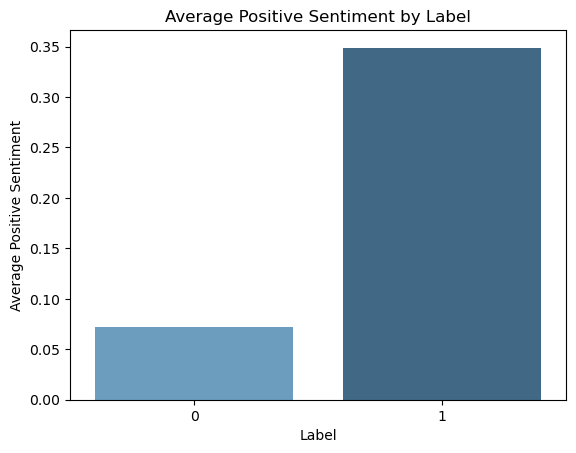

In [95]:
# Drop NaN values and group by 'label', then calculate the mean of 'positive'
data = df.dropna().groupby(['label'])['positive'].mean().reset_index()

# Create a bar plot
sns.barplot(data=data, 
            x='label', 
            y='positive', 
            palette='Blues_d')

# Add titles and labels 
plt.title('Average Positive Sentiment by Label')
plt.xlabel('Label')
plt.ylabel('Average Positive Sentiment')

# Show the plot
plt.show()

We see that spam emails are much more likely to be positive so we add a variable positive that takes the value 1 if it is positive and 0 otherwose.

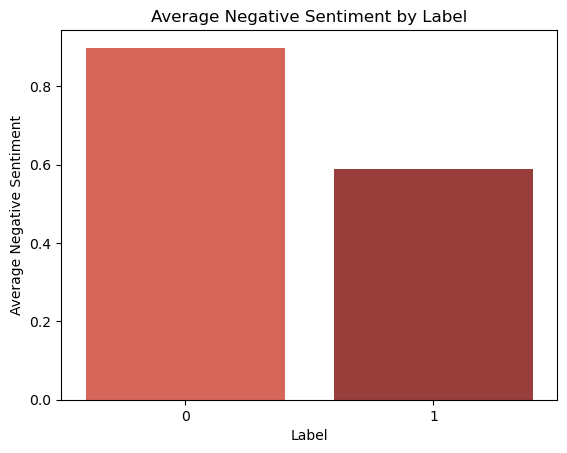

In [96]:
# Drop NaN values and group by 'label', then calculate the mean of 'negative'
data = df.dropna().groupby(['label'])['negative'].mean().reset_index()

# Create a bar plot
sns.barplot(data=data, 
            x='label', 
            y='negative', 
            palette='Reds_d')  

# Add titles and labels 
plt.title('Average Negative Sentiment by Label')
plt.xlabel('Label')
plt.ylabel('Average Negative Sentiment')

# Show the plot
plt.show()

This proves the point again as non spam emails are more negative.

In [97]:
# Create the 'sentiment' column based on the comparison
df['main_sentiment'] = df.apply(
    lambda row: 'positive' if row['positive'] > row['negative'] else 'negative',
    axis=1
)

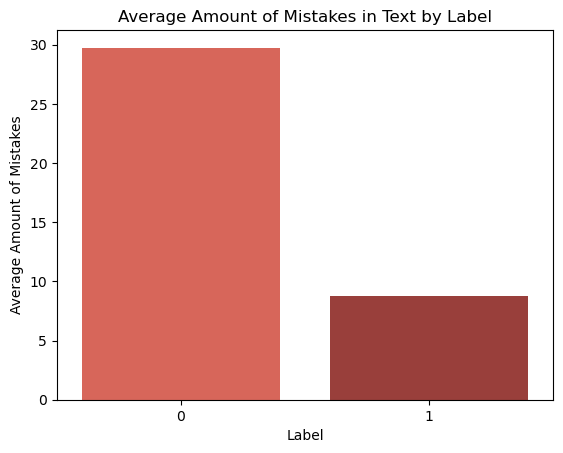

In [98]:
# Drop NaN values and group by 'label', then calculate the mean of 'negative'
data = df.dropna().groupby(['label'])['mistakes'].mean().reset_index()

# Create a bar plot
sns.barplot(data=data, 
            x='label', 
            y='mistakes', 
            palette='Reds_d')

# Add titles and labels 
plt.title('Average Amount of Mistakes in Text by Label')
plt.xlabel('Label')
plt.ylabel('Average Amount of Mistakes')

# Show the plot
plt.show()

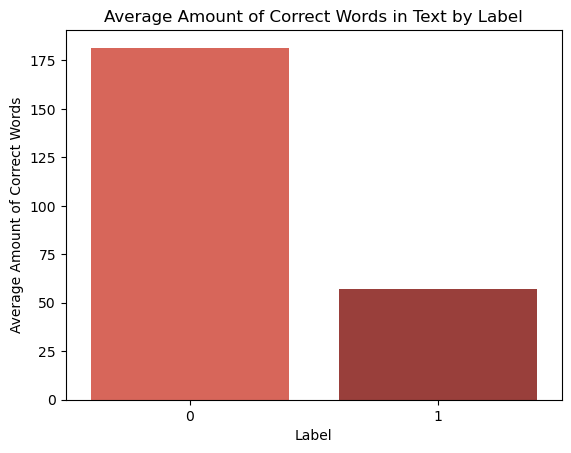

In [99]:
# Drop NaN values and group by 'label', then calculate the mean of 'negative'
data = df.dropna().groupby(['label'])['correct_count'].mean().reset_index()

# Create a bar plot
sns.barplot(data=data, 
            x='label', 
            y='correct_count', 
            palette='Reds_d')

# Add titles and labels
plt.title('Average Amount of Correct Words in Text by Label')
plt.xlabel('Label')
plt.ylabel('Average Amount of Correct Words')

# Show the plot
plt.show()

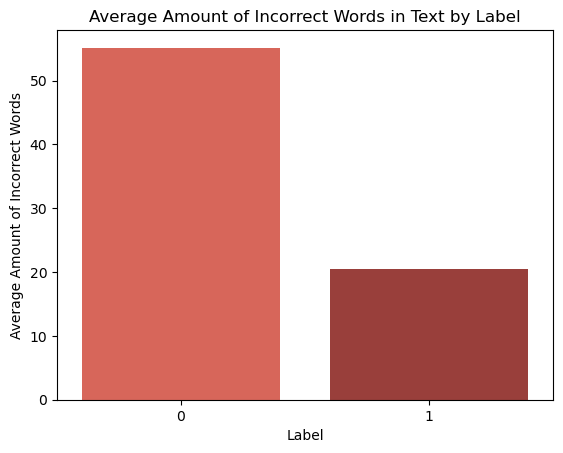

In [100]:
# Drop NaN values and group by 'label', then calculate the mean of 'negative'
data = df.dropna().groupby(['label'])['incorrect_count'].mean().reset_index()

# Create a bar plot
sns.barplot(data=data, 
            x='label', 
            y='incorrect_count', 
            palette='Reds_d')

# Add titles and labels 
plt.title('Average Amount of Incorrect Words in Text by Label')
plt.xlabel('Label')
plt.ylabel('Average Amount of Incorrect Words')

# Show the plot
plt.show()

The non spam emails have much higher average amount of mistakes, average amount of corrected words, as well as average amount of incorrect words. Therefore, there is not useful trend and we are not creating extra variables.

# Creating new columns for machine learning models

In [101]:
def is_late(time):
    """
    Determine if the given time is considered "late" based on a specific time range.

    This function checks if a given time falls within the "late" period, defined as between 19:00 (7:00 PM) and 07:00 (7:00 AM) the next day. It converts the input time to an hour and checks if it falls within the specified range. 

    Parameters:
    time (datetime.datetime): A `datetime` object representing the time to be checked.

    Returns:
    int: Returns 1 if the time is considered late (between 19:00 and 07:00), otherwise returns 0.
Notes:
    - The function assumes that the `time` parameter is a `datetime` object.
    - The time range considered "late" is from 19:00 (7:00 PM) to 07:00 (7:00 AM) the following day.
    - The function checks if the hour is within or outside this range and returns an integer to indicate whether it is late.
    """
    # Convert time to a number of hours
    hours = time.hour
    # Check if the time is between 19:00 and 07:00
    if hours >= 19 or hours < 7:
        return 1
    else:
        return 0

In [102]:
# Apply the function to create the 'Late' column
df['late'] = df['Time'].apply(is_late)

In [103]:
def extract_domain(sender):
    """
    Extract the domain from an email address.

    This function takes an email address as input and extracts the domain part from it. The domain is the part of the email address that comes after the '@' symbol. If the email address is valid and contains a domain, the function returns the domain. If the input does not contain a domain or is not a valid email address, the function returns `None`.

    Parameters:
    sender (str): The email address from which the domain is to be extracted.

    Returns:
    str or None: The domain part of the email address if it is found, otherwise `None`.
    """
    match = re.search(r'@([\w\.]+)', sender)
    return match.group(1) if match else None

In [104]:
def extract_name(sender):
    """
    Extract the name from an email address with optional display name.

    This function extracts the name part from an email address that might include an optional display name enclosed in angle brackets or quotes. If the input contains a name in this format, the function returns it. If the name cannot be extracted, the function returns `None`.

    Parameters:
    sender (str): The email address string which may include a display name.

    Returns:
    str or None: The extracted name if found, otherwise `None`.
    """
    match = re.search(r'["<](.*?)[">]', sender)
    return match.group(1) if match else None

In [105]:
# Apply the functions to create new columns
df['domain'] = df['sender'].apply(extract_domain)
df['name'] = df['sender'].apply(extract_name)

# Creating a categorical column for named or unnamed senders
df['is_named'] = df['name'].apply(lambda x: 1 if x else 0)

In [106]:
# Transform the 'domain' column into a string
df['domain'] = df['domain'].astype(str)

We then extract the TLD. A Top-Level Domain (TLD) is the last segment of a domain name, located after the final dot. It represents the highest level in the hierarchical Domain Name System (DNS) and helps identify the type or origin of the domain.

In [107]:
# Extract the TLD from the domain
df['tld'] = df['domain'].apply(lambda x: x.split('.')[-1])

In [108]:
# Group by label and TLD, then count the occurrences
tld_counts_per_label = df.groupby(['label', 'tld']).size().reset_index(name='count')

# Get the top 10 TLDs per label
top_10_tlds_per_label = tld_counts_per_label.groupby('label').apply(
    lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

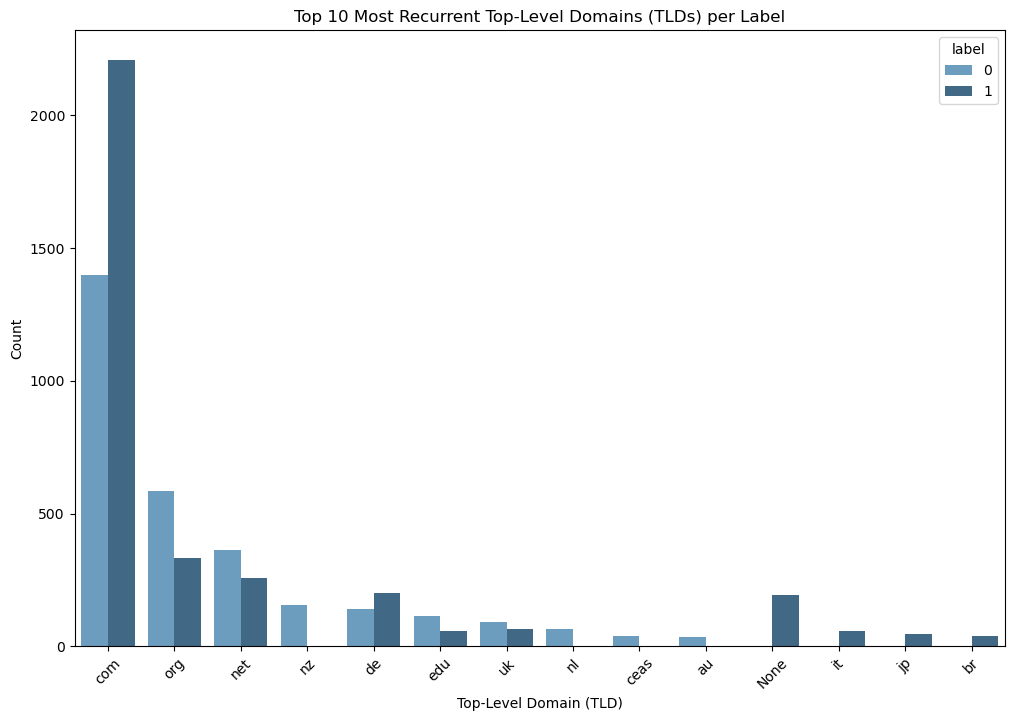

In [109]:
# Plot the top 10 TLDs for each label
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_tlds_per_label, x='tld', y='count', hue='label', palette='Blues_d')

# Add titles and labels
plt.title('Top 10 Most Recurrent Top-Level Domains (TLDs) per Label')
plt.xlabel('Top-Level Domain (TLD)')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Show the plot
plt.show()

We see that the TLDs are similar for spam and non spam emails and there isn't any trend relevant to analyze.

In [110]:
# Calculate the length of the domain
df['domain_length'] = df['domain'].apply(len)

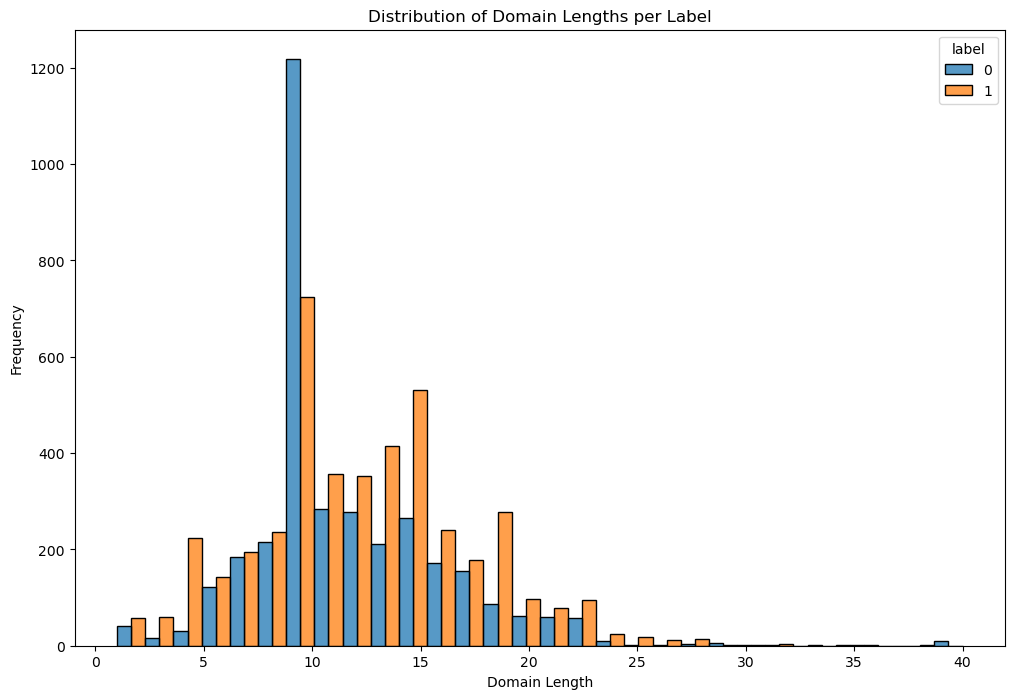

In [111]:
# Plot histograms of domain lengths per label, with bars next to each other
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='domain_length', hue='label', multiple='dodge', palette='tab10', kde=False, bins=30)

# Add titles and labels
plt.title('Distribution of Domain Lengths per Label')
plt.xlabel('Domain Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()

We notice that domain lengths are similar for spam and non spam emails. Therefore, we do not add any of this information to our model.

### Creating the variables discussed in the analysis

In [112]:
# Transform the 'subject' column into a string
df['subject'] = df['subject'].astype(str)

In [113]:
# Create the new column 'cnn'
df['cnn'] = df['subject'].apply(lambda x: 1 if 'cnn' in x.lower() else 0)

In [114]:
# Create the 'adwords' column
df['adwords'] = df['sender'].apply(lambda x: 1 if 'adwords' in x.lower() else 0)

In [115]:
def is_weekend(day_of_week, hour):
    """
    Determine if a given day and time falls within the weekend or late-night hours.

    This function checks if the provided day of the week and hour correspond to a weekend or late-night period. The weekend is considered to include Friday afternoons, all of Saturday, and Sunday until 5 AM. If the input day and time fall into these periods, the function returns `1` (indicating it is a weekend or late-night); otherwise, it returns `0`.

    Parameters:
    day_of_week (int): The day of the week represented as an integer where 0 is Monday and 6 is Sunday.
    hour (int): The hour of the day in 24-hour format (0 to 23).

    Returns:
    int: `1` if the day and hour fall within the weekend or late-night hours, `0` otherwise.
    """
    if (day_of_week == 4 and hour >= 14) or (day_of_week == 5) or (day_of_week == 6) or (day_of_week == 0 and hour < 5):
        return 1
    else:
        return 0

In [116]:
# Create the 'weekend' column using the function
df['weekend'] = df.apply(lambda row: is_weekend(row['DAY_OF_WEEK'], row['HOUR']), axis=1)
# Change weekend into a binary variable
df['weekend_int'] = df['weekend'].astype(int)

In [117]:
# Convert sentiment to 0 or 1 variable
df['sentpositive'] = df['main_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Machine Learning models

# Linear Regression

Linear regression is a simple machine learning model that predicts the value of a target variable by fitting a linear relationship to one or more input features.
We start with a logsitic regression model even though we do not assume it is the best model to use in this case. However, linear regression serves as a good baseline model. If a more complex model does not significantly outperform the linear regression model, it may indicate that the problem might not benefit from increased model complexity.

In [118]:
# Define features and target
X = df[['late','sentpositive','urls','is_named','cnn', 'adwords', 'weekend_int','contains_video', 'contains_crime', 'contains_index', 'contains_news', 'contains_alert', 'contains_python']]
y = df['label']

In [119]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [120]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [121]:
# Make predictions on the test data
y_pred = model.predict(X_test)

In [122]:
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.15158031120088442
R^2 Score: 0.3835569039471174


An MSE of 0.15 suggests that, on average, the squared differences between the model's predictions and the actual values are relatively low, but it still indicates some level of prediction error.
The R-squared score represents the proportion of the variance in the dependent variable that is predictable from the independent variables. An R² value of 0.3835 means that approximately 38.35% of the variance in the email being labeled spam is explained by the features in the model.

In [123]:
# Print the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [-0.04333595  0.38699112  0.10506047  0.10171814  1.16292945  0.59477293
  0.15642559 -0.09938752 -0.16660952 -0.18111682 -0.24499029 -0.35147036
 -0.49312984]
Intercept: 0.3345998327927956


Features such as sentpositive, is_named, cnn, adwords, and weekend_int are positively associated with an increased likelihood of an email being labeled as spam, meaning that higher values for these features generally raise the probability of an email being classified as spam.

In contrast to our initial expectations, the late feature has a negative coefficient, indicating that higher values for this feature are associated with a decreased probability of an email being classified as spam. 

The model's intercept value is 0.3346, which represents the baseline probability of an email being classified as spam when all feature values are zero.

# Create a Bag of Words Model of the documents

Bag of Words (BoW) model is a technique in natural language processing (NLP) and text analysis. It converts textual data into numerical features that can be used for machine learning models. It represents text data as a matrix of word counts or frequencies, disregarding grammar and word order but retaining the count of each word's occurrence in the document.

In [235]:
# Initialize an empty list to store the results
results = []

In [236]:
# Define features and target
X = df[['late','sentpositive','urls','is_named','cnn', 'adwords', 'weekend_int','contains_video', 'contains_crime', 'contains_index', 'contains_news', 'contains_alert','contains_python']]
y = df['label']

In [237]:
#Vectorizer and we limit limits the number of features (aka unique words or tokens) to include in the vectorizer to 10000
vectorizer = CountVectorizer(max_features=10000)

In [238]:
#Create the bag of words model
bow = vectorizer.fit_transform(df['cleaned_document'])

We then use the train_test_split function to divide the dataset into training and testing subsets to train and evaluate different machine learning models. We set the proportion of data used for testing  to 30% of our data and ensure reproducibility of the split by using a seed of 42.

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear kernel Support Vector Machine

A Linear Kernel Support Vector Machine (SVM) is a type of Support Vector Machine that uses a linear kernel to classify data. The primary goal of an SVM is to find a hyperplane that best separates the classes in the feature space. In other words, find a hyperplae that maximizes the margin between two classes. The margin is the distance between the hyperplane and the closest data points from each class (these closest points are called support vectors). We chose to use Linear Kernel SVMs for this specific case study because literature review has shown that it applies well in text classification tasks.

In [240]:
#model
model = SVC(kernel='linear')

In [241]:
#build the linear support vector machine
model.fit(X_train,y_train)

SVC(kernel='linear')

In [242]:
#get the predictions
y_pred = model.predict(X_test)

In [243]:
#return the fraction of correctly classified samples of the model
print("Accuracy of model is {}%".format(accuracy_score(y_test,y_pred) * 100))

Accuracy of model is 73.43550446998724%


In [244]:
# Compute evaluation metrics
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

In [245]:
# Saving the results
svm_results = {
    'Model': 'Linear SVM',
    'Accuracy': svm_accuracy,  
    'Precision': svm_precision, 
    'Recall': svm_recall,  
    'F1 Score': svm_f1  
}
results.append(svm_results)

In [246]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.92      0.75      1024
           1       0.91      0.59      0.71      1325

    accuracy                           0.73      2349
   macro avg       0.77      0.76      0.73      2349
weighted avg       0.79      0.73      0.73      2349



In [247]:
#Build the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

In [248]:
#display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

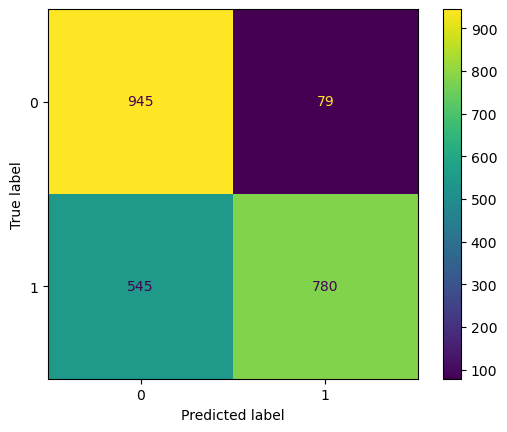

In [249]:
#plot the confusion matrix
disp.plot()

The confusion matrix shows that:
- True Positive = 780
- True Negative = 945
- False Positive = 79
- False Negative = 545
#### The confusion matrix indicates that the model performs well at identifying true positives and true negatives but struggles with a significant number of false negatives, where actual positives are incorrectly predicted as negatives.

# Radial Basis Function (RBF) kernel Support Vector Machine (SVM)

A Radial Basis Function (RBF) kernel Support Vector Machine (SVM) is a type of SVM that employs an RBF kernel to handle data that may not be linearly separable by mapping it into a higher-dimensional space where a linear decision boundary can be more effectively applied. The RBF kernel, also known as the Gaussian kernel, computes the similarity between data points by measuring their distance in the feature space, allowing the SVM to capture complex, non-linear relationships in the data. We opted for the RBF kernel in this study because it is well-suited for problems where the decision boundary between classes is not straightforward and can improve classification performance by accommodating intricate patterns in the data.

In [250]:
#model
model = SVC(kernel='rbf')

In [251]:
#build the linear support vector machine
model.fit(X_train,y_train)

SVC()

In [252]:
#get the predictions
y_pred = model.predict(X_test)

In [253]:
#return the fraction of correctly classified samples of the model
print("Accuracy of model is {}%".format(accuracy_score(y_test,y_pred) * 100))

Accuracy of model is 75.94721157939549%


In [254]:
# Compute evaluation metrics
rbf_accuracy= accuracy_score(y_test, y_pred)
rbf_precision = precision_score(y_test, y_pred)
rbf_recall = recall_score(y_test, y_pred)
rbf_f1 = f1_score(y_test, y_pred)

In [255]:
# Saving the results
rbf_results = {
    'Model': 'RBF',
    'Accuracy': rbf_accuracy,  
    'Precision': rbf_precision, 
    'Recall': rbf_recall,  
    'F1 Score': rbf_f1  
}
results.append(rbf_results)

In [256]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1024
           1       0.84      0.71      0.77      1325

    accuracy                           0.76      2349
   macro avg       0.76      0.77      0.76      2349
weighted avg       0.77      0.76      0.76      2349



In [257]:
#Build the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

In [258]:
#display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

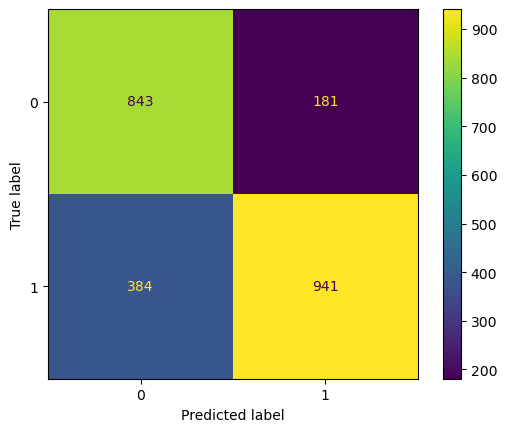

In [259]:
#plot the confusion matrix
disp.plot()

The confusion matrix shows that:
- True Positive = 941
- True Negative = 843
- False Positive = 181
- False Negative = 384
#### Similar to SVM, the confusion matrix indicates that the model performs well at identifying true positives and true negatives but struggles with a significant number of false negatives, where actual positives are incorrectly predicted as negatives.

# Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) is a dimensionality reduction and classification technique that aims to find the linear combination of features that best separates different classes in the data. By projecting the data onto a lower-dimensional space, LDA maximizes the between-class variance while minimizing the within-class variance, thereby enhancing class separability. We chose LDA for this study because it effectively reduces dimensionality while maintaining the discriminatory power of the features, making it particularly useful for high-dimensional datasets where distinguishing between classes is essential.

In [260]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [261]:
# Initialize LDA
lda = LinearDiscriminantAnalysis()

# Fit LDA model
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [262]:
# Transform the data
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

# Predict on the test set
y_pred = lda.predict(X_test)

In [263]:
# Generate the classification report
report = classification_report(y_test, y_pred)
lda_precision = precision_score(y_test, y_pred)
lda_recall = recall_score(y_test, y_pred)
lda_f1 = f1_score(y_test, y_pred)
lda_accuracy = accuracy_score(y_test, y_pred)

In [264]:
# Saving the results
lda_results = {
    'Model': 'LDA',
    'Accuracy': lda_accuracy,  
    'Precision': lda_precision, 
    'Recall': lda_recall,  
    'F1 Score': lda_f1  
}
results.append(lda_results)

In [265]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1024
           1       0.83      0.71      0.76      1325

    accuracy                           0.75      2349
   macro avg       0.76      0.76      0.75      2349
weighted avg       0.77      0.75      0.75      2349



In [266]:
#Build the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

In [267]:
#display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

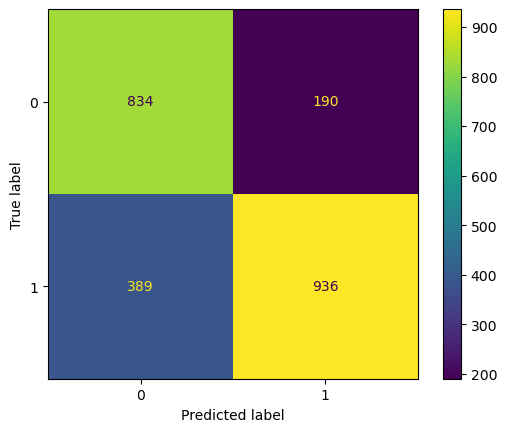

In [268]:
#plot the confusion matrix
disp.plot()

The confusion matrix shows that:
- True Positive = 936
- True Negative = 834
- False Positive = 190
- False Negative = 389
Similar to both previous models, the confusion matrix indicates that the model performs well at identifying true positives and true negatives but struggles with a significant number of false negatives, where actual positives are incorrectly predicted as negatives.

# Decision Tree

A Decision Tree is a machine learning algorithm that builds a model by recursively splitting the data into subsets based on feature values, resulting in a tree-like structure where each internal node represents a decision rule, each branch represents an outcome of that rule, and each leaf node represents a class label or predicted value. This approach allows for easy interpretation of the model's decision-making process and can handle both numerical and categorical data. We selected a Decision Tree for this study due to its ability to capture complex interactions between features and provide clear, visual insights into the decision boundaries used for classification.

In [269]:
# Initialize the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [270]:
# Make predictions on the test data
y_pred = tree_model.predict(X_test)

In [271]:
# Calculate the accuracy
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_f1 = f1_score(y_test, y_pred)

In [272]:
# Saving the results
dt_results = {
    'Model': 'Decision Tree',
    'Accuracy': dt_accuracy,  
    'Precision': dt_precision, 
    'Recall': dt_recall,  
    'F1 Score': dt_f1  
}
results.append(dt_results)

In [273]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1024
           1       0.84      0.72      0.77      1325

    accuracy                           0.76      2349
   macro avg       0.76      0.77      0.76      2349
weighted avg       0.77      0.76      0.76      2349



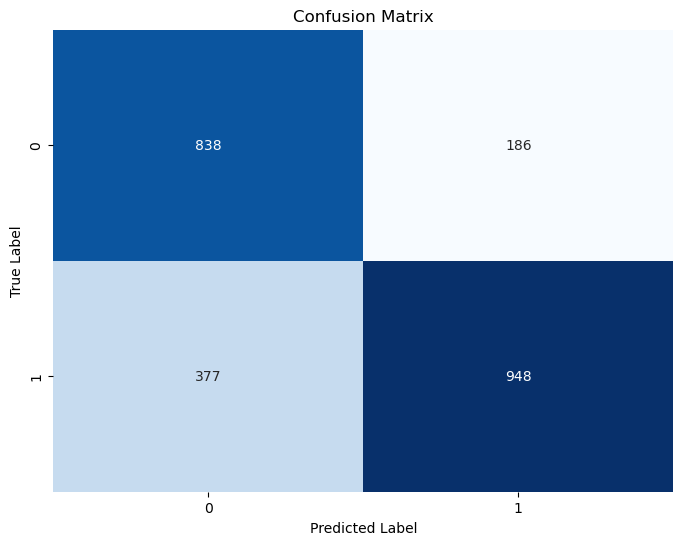

In [274]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The confusion matrix shows that:
- True Positive = 948
- True Negative = 838
- False Positive = 186
- False Negative = 377
#### Similar all 3 previous models, the confusion matrix indicates that the model performs well at identifying true positives and true negatives but struggles with a significant number of false negatives, where actual positives are incorrectly predicted as negatives.

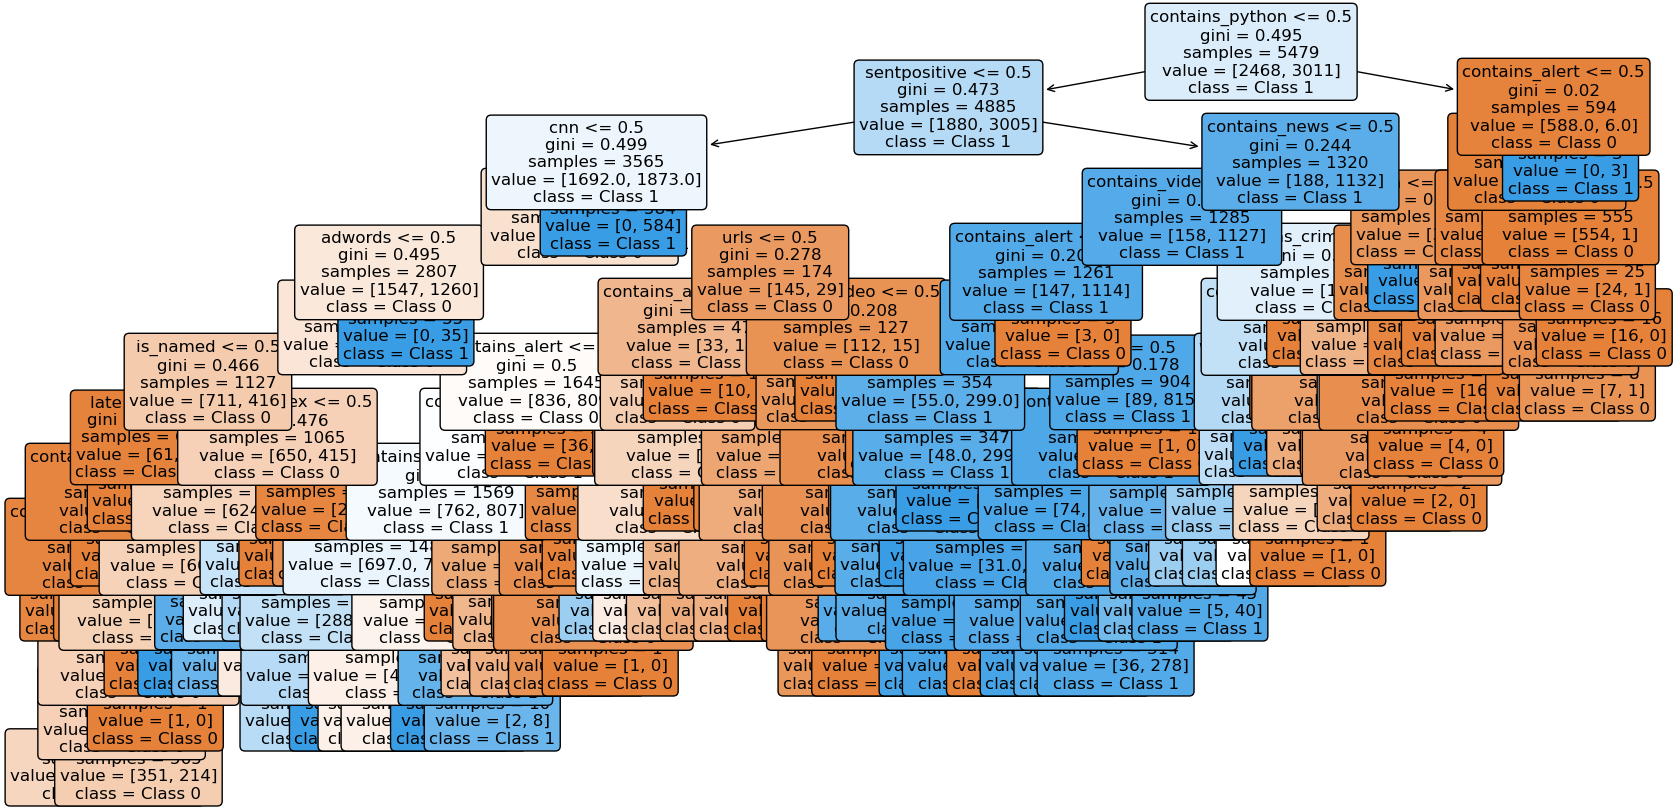

In [275]:
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'], rounded=True, fontsize=12)
plt.show()

The actual Decision Tree reveals that the most significant feature influencing predictions is if it contains the word python, followed directly by the positive sentiment. The tree then splits based on features such as contains news, contains alert, and CNN with subsequent branches incorporating URLs,adwords, whether names are present, and weekend status to further refine the classification.

# Random Forest

A Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode (most common prediction) of the classes from these individual trees for classification tasks. In this context, the Random Forest model aggregates the results from various decision trees, which individually consider features such as positive sentiment, CNN, AdWords, lateness, URLs, name presence, and weekend status. By combining these trees, the model enhances prediction accuracy and robustness compared to a single decision tree.

In [276]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [277]:
# Make predictions on the test data
y_pred = rf_model.predict(X_test)

In [278]:
# Calculate the metrics
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

In [279]:
# Saving the results
rf_results = {
    'Model': 'Random Forest',
    'Accuracy': rf_accuracy,  
    'Precision': rf_precision, 
    'Recall': rf_recall,  
    'F1 Score': rf_f1  
}
results.append(rf_results)

In [280]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1024
           1       0.84      0.72      0.77      1325

    accuracy                           0.76      2349
   macro avg       0.76      0.77      0.76      2349
weighted avg       0.77      0.76      0.76      2349



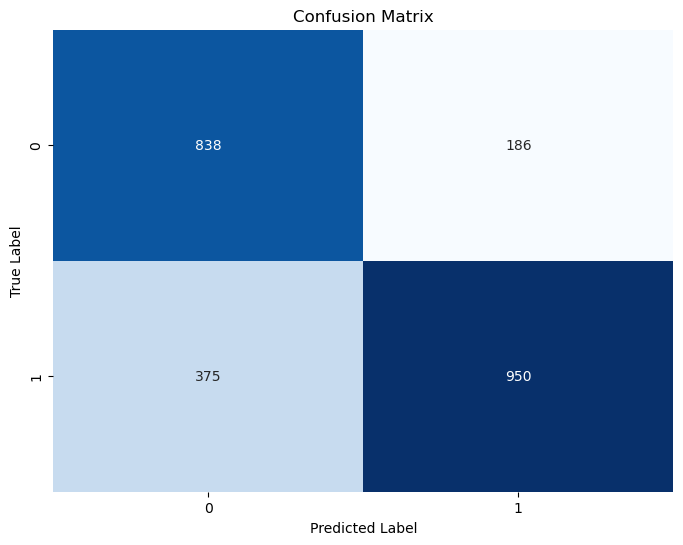

In [281]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The confusion matrix shows that:
- True Positive = 950
- True Negative = 838
- False Positive = 186
- False Negative = 375
#### Once again, the confusion matrix indicates that the model performs well at identifying true positives and true negatives but struggles with a significant number of false negatives, where actual positives are incorrectly predicted as negatives.

In [282]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

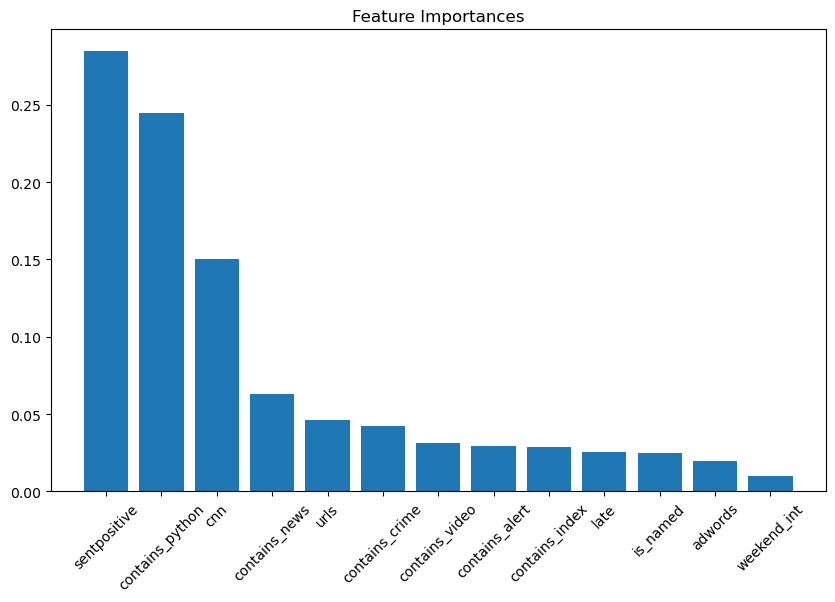

In [283]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

The feature importance shows similar results to that of the decision tree model with the positive sentiment being the most important, followed closely by the contains_poython and then the other variables are not so important with less than 0.15 weight.

# XGBoost

XGBoost (Extreme Gradient Boosting) is an advanced ensemble learning method that builds decision trees sequentially, where each new tree corrects the errors of the previous ones. It uses a gradient boosting framework to optimize the model by minimizing a loss function, making it highly efficient and effective for various predictive tasks. In the context of our model, XGBoost iteratively learns from features like positive sentiment, CNN, AdWords, lateness, URLs, name presence, and weekend status, producing a strong predictive model by combining the strengths of multiple trees while reducing errors progressively.

In [284]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [285]:
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

In [286]:
# Calculate the metrics
xg_accuracy = accuracy_score(y_test, y_pred)
xg_precision = precision_score(y_test, y_pred)
xg_recall = recall_score(y_test, y_pred)
xg_f1 = f1_score(y_test, y_pred)

In [287]:
# Saving the results
xg_results = {
    'Model': 'XGBoost',
    'Accuracy': xg_accuracy,  
    'Precision': xg_precision, 
    'Recall': xg_recall,  
    'F1 Score': xg_f1  
}
results.append(xg_results)

In [288]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1024
           1       0.84      0.72      0.77      1325

    accuracy                           0.76      2349
   macro avg       0.76      0.77      0.76      2349
weighted avg       0.77      0.76      0.76      2349



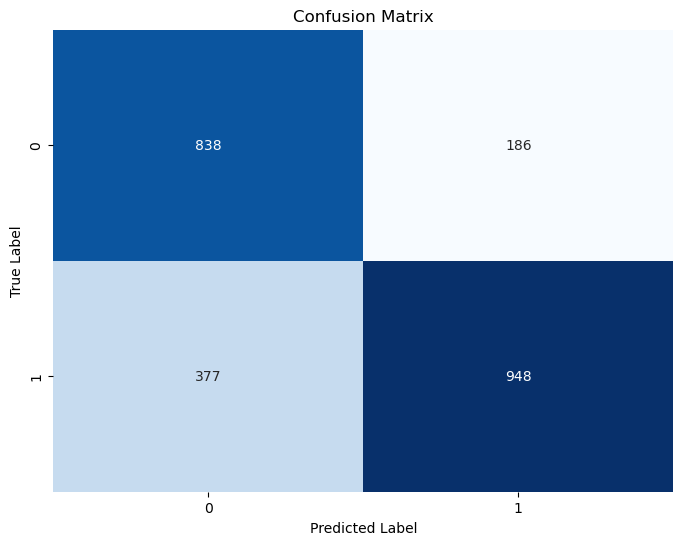

In [289]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The confusion matrix shows that:
- True Positive = 948
- True Negative = 838
- False Positive = 186
- False Negative = 377
##### Again, the confusion matrix indicates that the model performs well at identifying true positives and true negatives but struggles with a significant number of false negatives, where actual positives are incorrectly predicted as negatives.

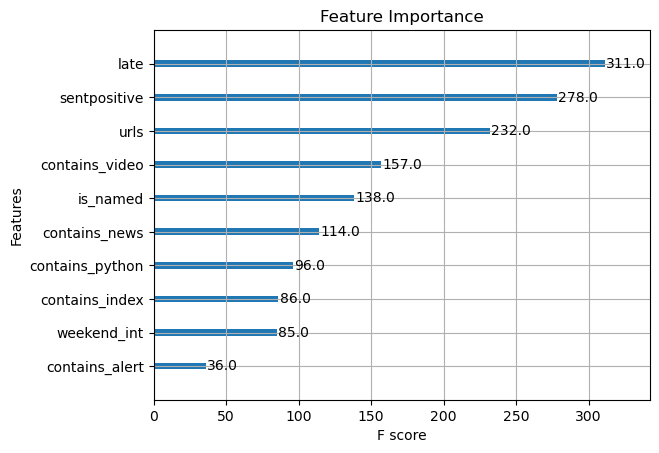

In [290]:
# Plot feature importances
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Feature Importance')
plt.show()

The feature importance is now different from the Random Forest model with late being the most important feature with an f-score of 311, followed closely by positive sentiment with 278, and URL with 232 and then the other features are less important.

# Summary of all models

In [291]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the results table
print(results_df)

           Model  Accuracy  Precision    Recall  F1 Score
0     Linear SVM  0.734355   0.908033  0.588679  0.714286
1            RBF  0.759472   0.838681  0.710189  0.769105
2            LDA  0.753512   0.831261  0.706415  0.763770
3  Decision Tree  0.760324   0.835979  0.715472  0.771045
4  Random Forest  0.761175   0.836268  0.716981  0.772044
5        XGBoost  0.760324   0.835979  0.715472  0.771045


Most models demonstrate similar performance with only minor differences in accuracy and F1 scores. Precision remains consistently high across all models, indicating strong performance in correctly identifying positive cases. However, recall is relatively lower, suggesting that the models may be overlooking some positive instances. Among the models, Decision Tree, Random Forest, and XGBoost exhibit slight improvements in both accuracy and F1 score, making them more effective at both correctly identifying positive cases and capturing a higher proportion of actual positives compared to the other models.

#### A next step would be to hypertune the XGBoost model to improve its performance. We aim to optimize the model's hyperparameters to find the best combination that maximizes the model's performance using grid search with cross-validation. 

In [292]:
from sklearn.model_selection import GridSearchCV

In [293]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

In [294]:
# Set up the parameter grid with some common hyperparameters for XGBoost 
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In the next step, we efine the gridsearch cv:
- cv=5 indicates 5-fold cross-validation.
- scoring='recall' indicates that recall is the primary metric to optimize. 
- n_jobs=-1 uses all available cores for computation, speeding up the grid search process.

In [295]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='recall', n_jobs=-1, verbose=2)

In [296]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='recall', verbose=2)

In [297]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}


In [298]:
# Train the final model with the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [299]:
# Predict on the test set
y_pred = best_xgb_model.predict(X_test)

In [300]:
# Calculate the metrics
xg_optimized_accuracy = accuracy_score(y_test, y_pred)
xg_optimized_precision = precision_score(y_test, y_pred)
xg_optimized_recall = recall_score(y_test, y_pred)
xg_optimized_f1 = f1_score(y_test, y_pred)

In [301]:
# Saving the results
xg_optimized_results = {
    'Model': 'XGBoost Optimized',
    'Accuracy': xg_optimized_accuracy,  
    'Precision': xg_optimized_precision, 
    'Recall': xg_optimized_recall,  
    'F1 Score': xg_optimized_f1  
}
results.append(xg_optimized_results)

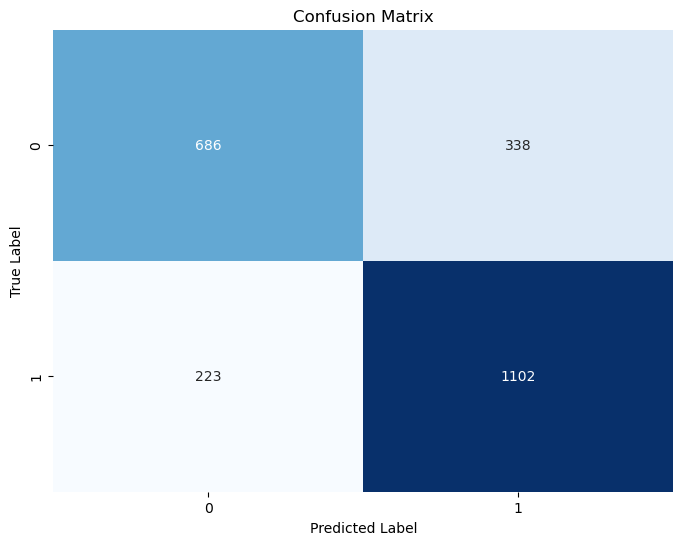

In [302]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Adding the optimized XG Boost model to the summary of all tables

In [304]:
# Display the results table
print(results_df)

               Model  Accuracy  Precision    Recall  F1 Score
0         Linear SVM  0.734355   0.908033  0.588679  0.714286
1                RBF  0.759472   0.838681  0.710189  0.769105
2                LDA  0.753512   0.831261  0.706415  0.763770
3      Decision Tree  0.760324   0.835979  0.715472  0.771045
4      Random Forest  0.761175   0.836268  0.716981  0.772044
5            XGBoost  0.760324   0.835979  0.715472  0.771045
6  XGBoost Optimized  0.761175   0.765278  0.831698  0.797107
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_